<div style="position: relative;"> 
  <h1 style="position: relative">Leasing Price Predictor</h1>

  <img src="components/wu-logo.png" alt="Logo" width="150" height="auto" style="position: absolute; top: 0; right: 0;">

  created by:

    Tobias Ponesch
    Sina Haghgoo
    Finnian John Dempsey
    Vinicius Wolff
    Adrian Lehrner

  In cooperation with:
  
  <img src="components/zeb-logo.png" alt="ZEB" width="200" height="auto">

  This work draws inspiration from the master thesis conducted by Thomas Dornigg. To delve deeper into Dornigg's thesis, please refer to the following link:

  https://nbviewer.org/github/ThomasD96/University_Repo/blob/master/Nova_SBE/Master_thesis/Credit_Risk_Modeling.ipynb
</div>

## Table of Contents

1. [Import Libraries](#import-libraries)
2. [Computational effort](#computational-effort)
3. [Dataset import](#dataset-import)
4. [Basic Preprocessing](#basic-preprocessing)
5. [Explanatory Data Analysis](#explanatory-analysis)
   - 5.1 [The Target variable](#target-variable)
   - 5.2 [Numerical Features](#numerical-features)
     - 5.2.1 [Skewness of numerical variables](#skewness)
   - 5.3 [Categorical Features](#categorical-features)
   - 5.4 [Target variable vs. categorical features](#target-cat)
   - 5.5 [Heatmap (Correlations)](#heatmap)
     - 5.5.1 [Dropping kilowatts](#drop-kilowatts)
6. [Preprocessing and Feature Engineering](#preprocessing)
   - 6.1 [Missing Values](#missing-values)
   - 6.2 [Cardinality of non-numeric features](#cardinality)
   - 6.3 [Problems with splitting -- STILL OPEN](#splitting-problem)
   - 6.4 [Out of Sample split](#osample-split)
   - 6.5 [Train and Test split](#train-test-split)
   - 6.6 [Transformer Pipelines](#transformer-pipelines)
7. [Machine Learning Modeling](#machine-learning-modeling)
   - 7.1 [Choosing appropriate metric & customization approach](#metric)
   - 7.2 [Decision Tree](#decision-tree)
   - 7.3 [Random Forest](#random-forest)
   - 7.4 [K-nearest neighbor](#k-neighbors)
   - 7.5 [XGB](#xgb)
   - 7.6 [Support-Vector-Machines (SVM)](#svm)
8. [Test Data Performance](#test-performance)
   - 8.1 [Metrics comparison](#test-metrics-comparison)
   - 8.2 [Predicted vs actual plots](#test-predicted-actual)
   - 8.3 [Histogram of residuals](#test-histograms)
9. [Out of sample performance](#osample-performance)
   - 9.1 [Metrics comparison](#osample-metrics-comparison)
   - 9.2 [Predicted vs actual plots](#osample-predicted-actual)
   - 9.3 [Histogram of residuals](#osample-histograms)
10. [Feature Importance Analysis](#feature-importance)
    - 10.1 [Decision tree feature importance](#importance-decisiontree)
    - 10.2 [Random forest feature importance](#importance-randomForest)
    - 10.3 [XGB feature importance](#importance-xgb)
11. [Light models (reduced complexity)](#light-models)
    - 11.1 [Best two performing full models](#light-best)
        - 11.1.1 [Random Forest](#light-forest)
        - 11.1.2 [XGB](#light-xgb)
    - 11.2 [Performance full vs light models](#light-comparison)
        - 11.2.1 [Performance full vs light models](#light-comparison-PvA)
12. [Safe models](#safe-models)
13. [Debugging library versions](#debugging-libraries)


## 1 Import Libraries<a id="import-libraries"></a>

In [1]:
import pandas as pd
import numpy as np

#Sklearn Preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

#Sklearn model builder:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#XGB model
from xgboost import XGBRegressor

#Sklearn metrics:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

#Model evaluation
import shap
from sklearn.metrics import PredictionErrorDisplay

#from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler


#from sklearn.preprocessing import OneHotEncoder

#Other helper libraries
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
from joblib import dump, load
import multiprocessing
import psutil
import threading
import time
import os

# Might cause a warning about the Numba / shap version combination. For now, this can be ignored

c:\Users\Tobia\anaconda3\envs\py39\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Tobia\anaconda3\envs\py39\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

## 2 Computational effort<a id="computational-effort"></a>

In [2]:
# ---- EXECUTE THIS CELL ----
calc_models = input("If you want to compute the models, enter \"Yes\", or \"Y\". If you want to load the existing models, enter \"No\",\"N\":")
calc_models = calc_models.lower()
allowed=["yes", "y", "no", "n"]
while calc_models not in allowed:
    print("Invalid input. Please try again.")
    calc_models = input("If you want to compute the models, enter \"Yes\", or \"Y\". If you want to load the existing models, enter \"No\",\"N\":")
    calc_models.lower()

if calc_models in ["yes","y"]:
    compute = True
else:
    compute = False    


if compute:
    allowed_values = ["ludicrous", "high", "medium", "low"]

    comp_effort = input("Enter your computational performance (Ludicrous, High, Medium, or Low): ")
    comp_effort = comp_effort.lower()

    while comp_effort not in allowed_values:
        print("Invalid input. Please try again.")
        comp_effort = input("Enter your computational performance (Ludicrous, High, Medium, or Low): ")
        comp_effort = comp_effort.lower()

    # The user input is valid
    print("Your computational performance:", comp_effort)

    #To ensure machine usability while executing models, we define usable cores
    available_cores = multiprocessing.cpu_count()



## 3 Dataset import <a id="dataset-import"></a>

In [3]:
datafolder = "data"
modelfolder = "models/current"

In [4]:
df = pd.read_excel(f'{datafolder}/dataset_2023.xlsx')
df = df.drop('Unnamed: 0', axis = 1)
df

brand_name                         model_name      milage   
0           Skoda  Octavia ŠKODA Combi Style TDI DSG      201 km  \
1      Volkswagen                T-Cross VW Life TSI      201 km   
2            Seat              Ibiza Austria Edition   15.000 km   
3      Volkswagen                            Polo VW        1 km   
4            Audi     A4 Avant 40 TDI quattro S line  105.301 km   
...           ...                                ...         ...   
19053        Seat        Ateca FR 2.0 TDI DSG 4Drive      201 km   
19054       Skoda  Octavia ŠKODA Combi Style TDI DSG      201 km   
19055        Audi     A4 Avant 40 TDI quattro S line  105.301 km   
19056  Volkswagen                            Polo VW   18.903 km   
19057  Volkswagen                 Tiguan VW Life TDI   48.000 km   

      first_registration              duration                gear   
0                03/2023  48 Monat (anpassbar)           Automatik  \
1                03/2023  48 Monat (anpassbar)  Manuelle Schaltung   
2                10/2022  48 Monat (anpassbar)  Manuelle Schaltung   
3                01/2023  48 Monat (anpassbar)  Manuelle Schaltung   
4                12/2019  48 Monat (anpassbar)           Automatik   
...                  ...                   ...                 ...   
19053            01/2023  48 Monat (anpassbar)           Automatik   
19054            03/2023  48 Monat (anpassbar)           Automatik   
19055            12/2019  48 Monat (anpassbar)           Automatik   
19056            06/2020  48 Monat (anpassbar)  Manuelle Schaltung   
19057            09/2022  48 Monat (anpassbar)  Manuelle Schaltung   

      monthly_fee emission_value   consumption horsepower kilowatts fuel_type  
0        574,01 €       119 g/km  5,0 l/100 km     150 PS    110 kW    Diesel  
1        382,58 €       131 g/km  6,0 l/100 km      95 PS     70 kW    Benzin  
2        239,62 €       120 g/km  5,0 l/100 km      80 PS     59 kW    Benzin  
3        309,11 €       127 g/km  6,0 l/100 km      80 PS     59 kW    Benzin  
4        587,75 €       138 g/km  5,0 l/100 km     190 PS    140 kW    Diesel  
...           ...            ...           ...        ...       ...       ...  
19053    692,03 €       146 g/km  6,0 l/100 km     150 PS    110 kW    Diesel  
19054    574,01 €       187 g/km  8,0 l/100 km     150 PS    110 kW    Diesel  
19055    587,75 €       143 g/km  6,0 l/100 km     190 PS    140 kW    Diesel  
19056    256,33 €        40 g/km  2,0 l/100 km      80 PS     59 kW    Benzin  
19057    539,72 €       185 g/km  8,0 l/100 km     122 PS     90 kW    Diesel  

[19058 rows x 12 columns]

In [5]:
#Enter the actual column names
brand = "brand_name"
model = "model_name"
milage = "milage"
registration = "first_registration"
duration = "duration"
gear = "gear"
fee = "monthly_fee"
emission = "emission_value"
consumption = "consumption"
horsepower = "horsepower"
kilowatts = "kilowatts"
fuel = "fuel_type"

rename_columns = {
    brand:"brand",
    model:"model",
    milage:"milage",
    registration:"registration",
    duration:"duration",
    gear:"gear",
    fee:"fee",
    emission:"emission",
    consumption:"consumption",
    horsepower:"horsepower",
    kilowatts:"kilowatts",
    fuel:"fuel"
}

df = df.rename(columns=rename_columns)
df

brand                              model      milage registration   
0           Skoda  Octavia ŠKODA Combi Style TDI DSG      201 km      03/2023  \
1      Volkswagen                T-Cross VW Life TSI      201 km      03/2023   
2            Seat              Ibiza Austria Edition   15.000 km      10/2022   
3      Volkswagen                            Polo VW        1 km      01/2023   
4            Audi     A4 Avant 40 TDI quattro S line  105.301 km      12/2019   
...           ...                                ...         ...          ...   
19053        Seat        Ateca FR 2.0 TDI DSG 4Drive      201 km      01/2023   
19054       Skoda  Octavia ŠKODA Combi Style TDI DSG      201 km      03/2023   
19055        Audi     A4 Avant 40 TDI quattro S line  105.301 km      12/2019   
19056  Volkswagen                            Polo VW   18.903 km      06/2020   
19057  Volkswagen                 Tiguan VW Life TDI   48.000 km      09/2022   

                   duration                gear       fee  emission   
0      48 Monat (anpassbar)           Automatik  574,01 €  119 g/km  \
1      48 Monat (anpassbar)  Manuelle Schaltung  382,58 €  131 g/km   
2      48 Monat (anpassbar)  Manuelle Schaltung  239,62 €  120 g/km   
3      48 Monat (anpassbar)  Manuelle Schaltung  309,11 €  127 g/km   
4      48 Monat (anpassbar)           Automatik  587,75 €  138 g/km   
...                     ...                 ...       ...       ...   
19053  48 Monat (anpassbar)           Automatik  692,03 €  146 g/km   
19054  48 Monat (anpassbar)           Automatik  574,01 €  187 g/km   
19055  48 Monat (anpassbar)           Automatik  587,75 €  143 g/km   
19056  48 Monat (anpassbar)  Manuelle Schaltung  256,33 €   40 g/km   
19057  48 Monat (anpassbar)  Manuelle Schaltung  539,72 €  185 g/km   

        consumption horsepower kilowatts    fuel  
0      5,0 l/100 km     150 PS    110 kW  Diesel  
1      6,0 l/100 km      95 PS     70 kW  Benzin  
2      5,0 l/100 km      80 PS     59 kW  Benzin  
3      6,0 l/100 km      80 PS     59 kW  Benzin  
4      5,0 l/100 km     190 PS    140 kW  Diesel  
...             ...        ...       ...     ...  
19053  6,0 l/100 km     150 PS    110 kW  Diesel  
19054  8,0 l/100 km     150 PS    110 kW  Diesel  
19055  6,0 l/100 km     190 PS    140 kW  Diesel  
19056  2,0 l/100 km      80 PS     59 kW  Benzin  
19057  8,0 l/100 km     122 PS     90 kW  Diesel  

[19058 rows x 12 columns]

In [6]:
SEED = 2023
TARGET_name = "fee"
FEATURE_names = df.drop(TARGET_name, axis=1).columns

## 4 Basic Preprocessing<a id="basic-preprocessing"></a>

In [7]:
class CalculateAge(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        pass
    
    def transform(self, X, y=None):
        print(self.columns)
        def calculate_age(registration_date):
            if registration_date == "Neuwagen":
                return 0
            else:
                today = datetime.now()
                date = datetime.strptime(registration_date, "%m/%Y")
                delta = relativedelta(today, date)
                return (delta.years * 12) + delta.months
        Xc = X.copy()
        if self.columns:
            columns = self.columns
        else:
            columns = Xc.columns
        Xc[columns[0]] = Xc[columns[0]].replace(["","nan"], np.nan)
        Xc[columns[0]] = Xc[columns[0]].apply(calculate_age)
        return Xc

class RemoveUnits(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def extractFloats(input):
            try:
                input = input.split(" ")[0]
                f = float(input.replace('.','').replace(',','.'))
                return(f)
            except AttributeError:
                return input        
        
        X_=X.copy()
        columns = X.columns
        X_[columns] = X_[columns].apply(lambda col: col.replace(["","nan"], np.nan))
        X_[columns] = X_[columns].apply(lambda col: col.apply(extractFloats))
        return X_
        
    def get_feature_names_out(self):
        pass
       

In [8]:
units = ["milage", "duration", "fee", "emission", "consumption", "horsepower", "kilowatts"]

basicpreprocessor = ColumnTransformer(
    transformers=[
        ('age', CalculateAge(),["registration"]),
        ('unit', RemoveUnits(),units)
    ],
    remainder = "passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

df = basicpreprocessor.fit_transform(df)
df.head()

None


registration    milage  duration     fee  emission  consumption   
0             2     201.0      48.0  574.01     119.0          5.0  \
1             2     201.0      48.0  382.58     131.0          6.0   
2             7   15000.0      48.0  239.62     120.0          5.0   
3             4       1.0      48.0  309.11     127.0          6.0   
4            41  105301.0      48.0  587.75     138.0          5.0   

   horsepower  kilowatts       brand                              model   
0       150.0      110.0       Skoda  Octavia ŠKODA Combi Style TDI DSG  \
1        95.0       70.0  Volkswagen                T-Cross VW Life TSI   
2        80.0       59.0        Seat              Ibiza Austria Edition   
3        80.0       59.0  Volkswagen                            Polo VW   
4       190.0      140.0        Audi     A4 Avant 40 TDI quattro S line   

                 gear    fuel  
0           Automatik  Diesel  
1  Manuelle Schaltung  Benzin  
2  Manuelle Schaltung  Benzin  
3  Manuelle Schaltung  Benzin  
4           Automatik  Diesel

In [9]:
basicpreprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('age', CalculateAge(), ['registration']),
                                ('unit', RemoveUnits(),
                                 ['milage', 'duration', 'fee', 'emission',
                                  'consumption', 'horsepower', 'kilowatts'])],
                  verbose_feature_names_out=False)

In [10]:
TARGET = pd.DataFrame(df["fee"])
num_FEATURES = df[df.select_dtypes(include=['float64', 'int64']).columns].drop("fee", axis=1)
cat_FEATURES = df[df.select_dtypes(exclude=['float64', 'int64']).columns]

## 5 Explanatory Data Analysis<a id="explanatory-analysis"></a>

During the exploratory data analysis (EDA) conducted for this project, a comprehensive examination of the dataset was performed to uncover relevant aspects about our dataset such as: trends, patterns, anomalies, and relationships. Initially, basic statistical measures and graphical representations of our target variable were utilized to gain a basic understanding of the predictor of our dataset. Additionally we wanted to further investigate the numerical and categorical variables in order to get a much better overview of all the other relevant features of our dataset and investigate their correlation with our target variable. 

### 5.1 The Traget variable <a id="target-variable"></a>

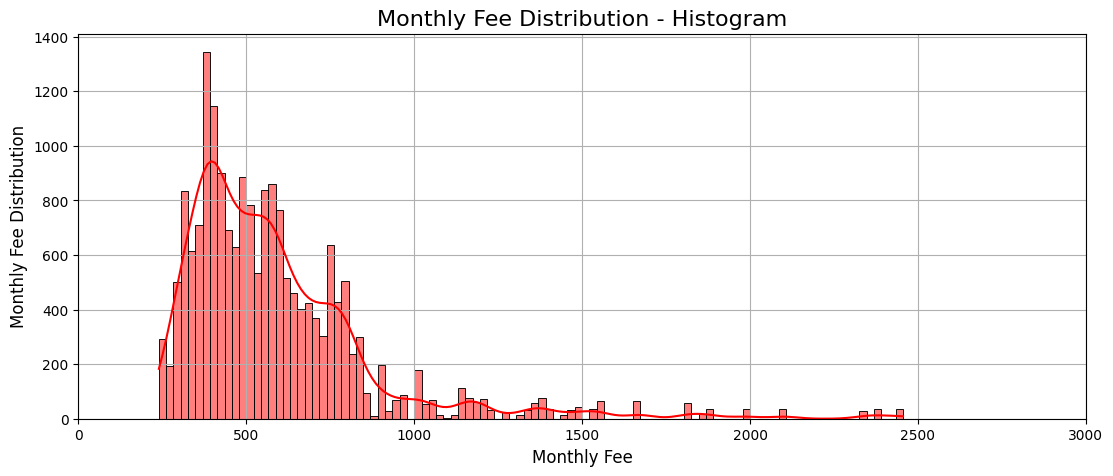

In [11]:
# Histogram
hist_color = 'red'
title_font_size = 16
label_font_size = 12
plt.figure(figsize=(13,5))
sns.histplot(TARGET['fee'], kde=True, color=hist_color)
plt.title('Monthly Fee Distribution - Histogram', fontsize=title_font_size) #### ÄNDERN IN AMOUNT OF "CARS"
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.xticks(ticks=plt.xticks()[0][::1])  
plt.ylabel('Monthly Fee Distribution', fontsize=label_font_size)
plt.grid(True)
plt.show()

On this histogramm we see the monthly fee distrubtion for the cars in the dataset. The distribution exhibits a right-skewed pattern, indicating that a majority of the leasing rates fall towards the lower end of the scale with minimum leasing rates. starting from approximately 250 euros. The peak of the distribution occurs around 350 euros, with a significant number of cars falling within this monthly fee range. Most of the values lie between 300-900 euros. What is interresting is that we can see that there are very few cars that have a leasing rate between 2000 and 2500 euros. Those cars are not outliers but rather just very expensive cars. 

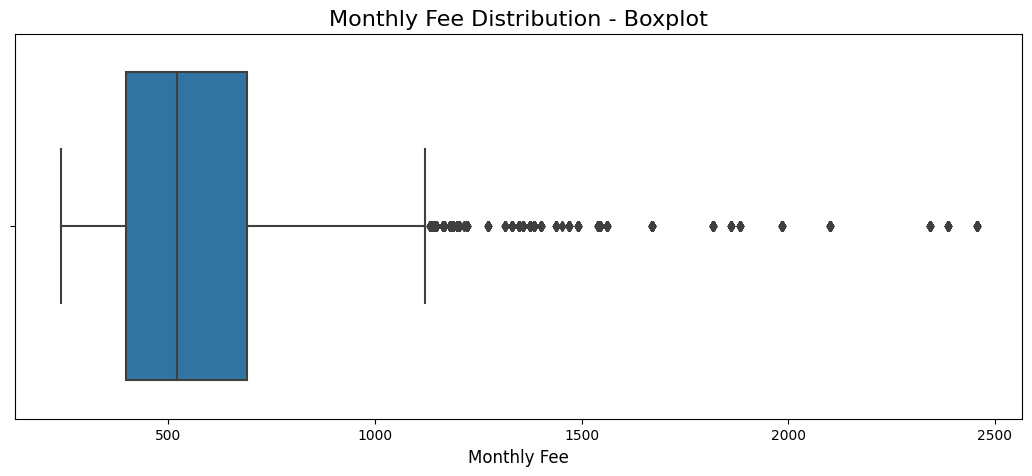

In [12]:
# Boxplot
plt.figure(figsize=(13,5))
sns.boxplot(x=df['fee'])
plt.title('Monthly Fee Distribution - Boxplot', fontsize=title_font_size) # auch ändern 
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.show()

The boxplot for the monthy fee distribution verifies what we observed from the histogram. The minimum monthly fee value is approximately 250 euros, while the maximum reaches up to 1200 euros. The median, which represents the middle value of the distribution, lies slightly above 500 euros. Upon closer examination, it becomes apparent that the boxplot exhibits numerous outliers. However (as stated earlier), these outliers are not indicative of data anomalies but rather represent the presence of very expensive cars with exceptionally high leasing rates. This observation highlights the diversity within the dataset, as it encompasses both affordable and luxury vehicles.

### 5.2 Numerical Features <a id="numerical-features"></a>

5.2.1 scatterplot for numerical features vs target variable

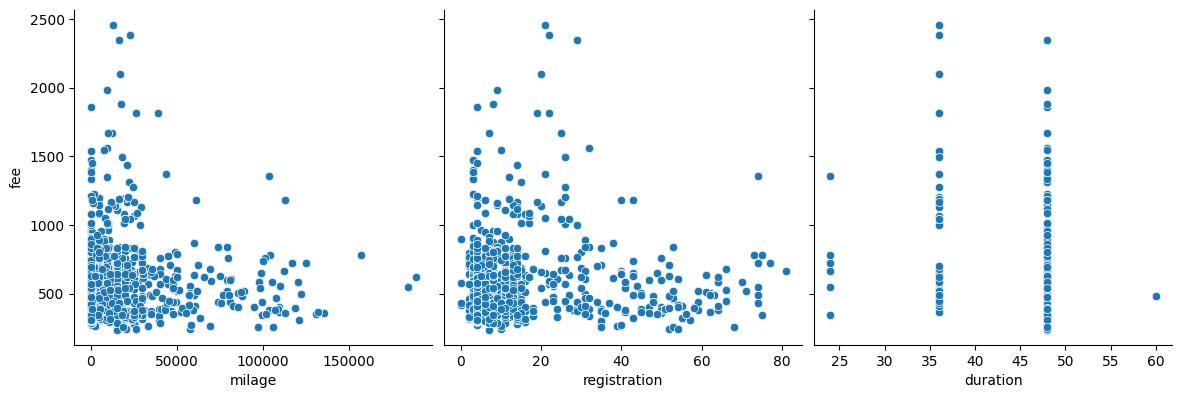

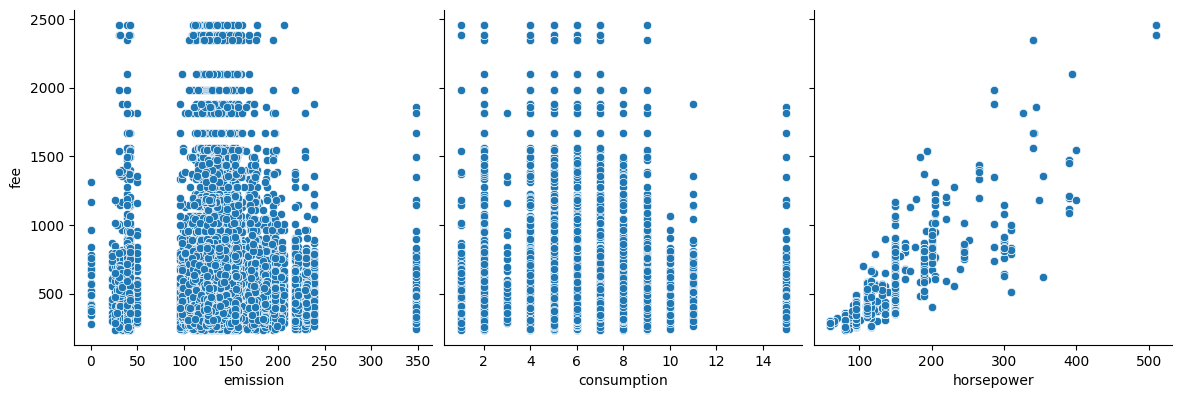

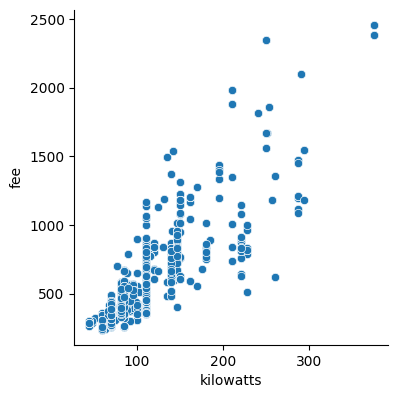

In [13]:
def pp(x,y,z):
    sns.pairplot(df, x_vars=[x,y,z], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('milage', 'registration', 'duration')
pp('emission', 'consumption', 'horsepower')

def pp(x):
    sns.pairplot(df, x_vars=[x], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('kilowatts')

Scatterplots provide a visual representation to explore the relationship between numerical variables and the target variable in our dataset. In our analysis, we plotted our target variable on the y-axis against all the numeric variables on the x-axis.

From the scatterplots, several key findings emerged. First, a strong linear relationship was observed between the monthly fee and the horsepower. As the horsepower increases, the monthly fee tends to rise as well, indicating a positive correlation between these variables.

Additionally, we discovered that lower mileage and more recent initial registrations are associated with higher monthly fees. This relationship is evident from the concentrated distribution of points in the corresponding regions of the scatterplots, suggesting that these factors have a noticeable impact on leasing rates.

Examining the scatterplots for consumption and duration, we noticed an interresting pattern. Despite variations in duration and consumption, the monthly fees are relatively evenly distributed. This implies that these variables may not exert a significant influence on the monthly fee, as indicated by the consistent spread of points across different durations and consumption levels.

Regarding the emission variable, we observed a dense cluster of points in the middle range, signifying a large number of vehicles with emission values between approx. 100-250. This indicates that both low-cost and high-cost vehicles exist within this emission range, potentially reflecting a diverse market segment with various pricing factors beyond emissions alone.

Overall, these insights from the scatterplots shed light on the relationships between the numerical variables and the monthly fee, providing valuable information for feature selection and understanding the factors influencing leasing rates.

#### 5.2.1 Skewness of numerical variables <a id="skewness"></a>

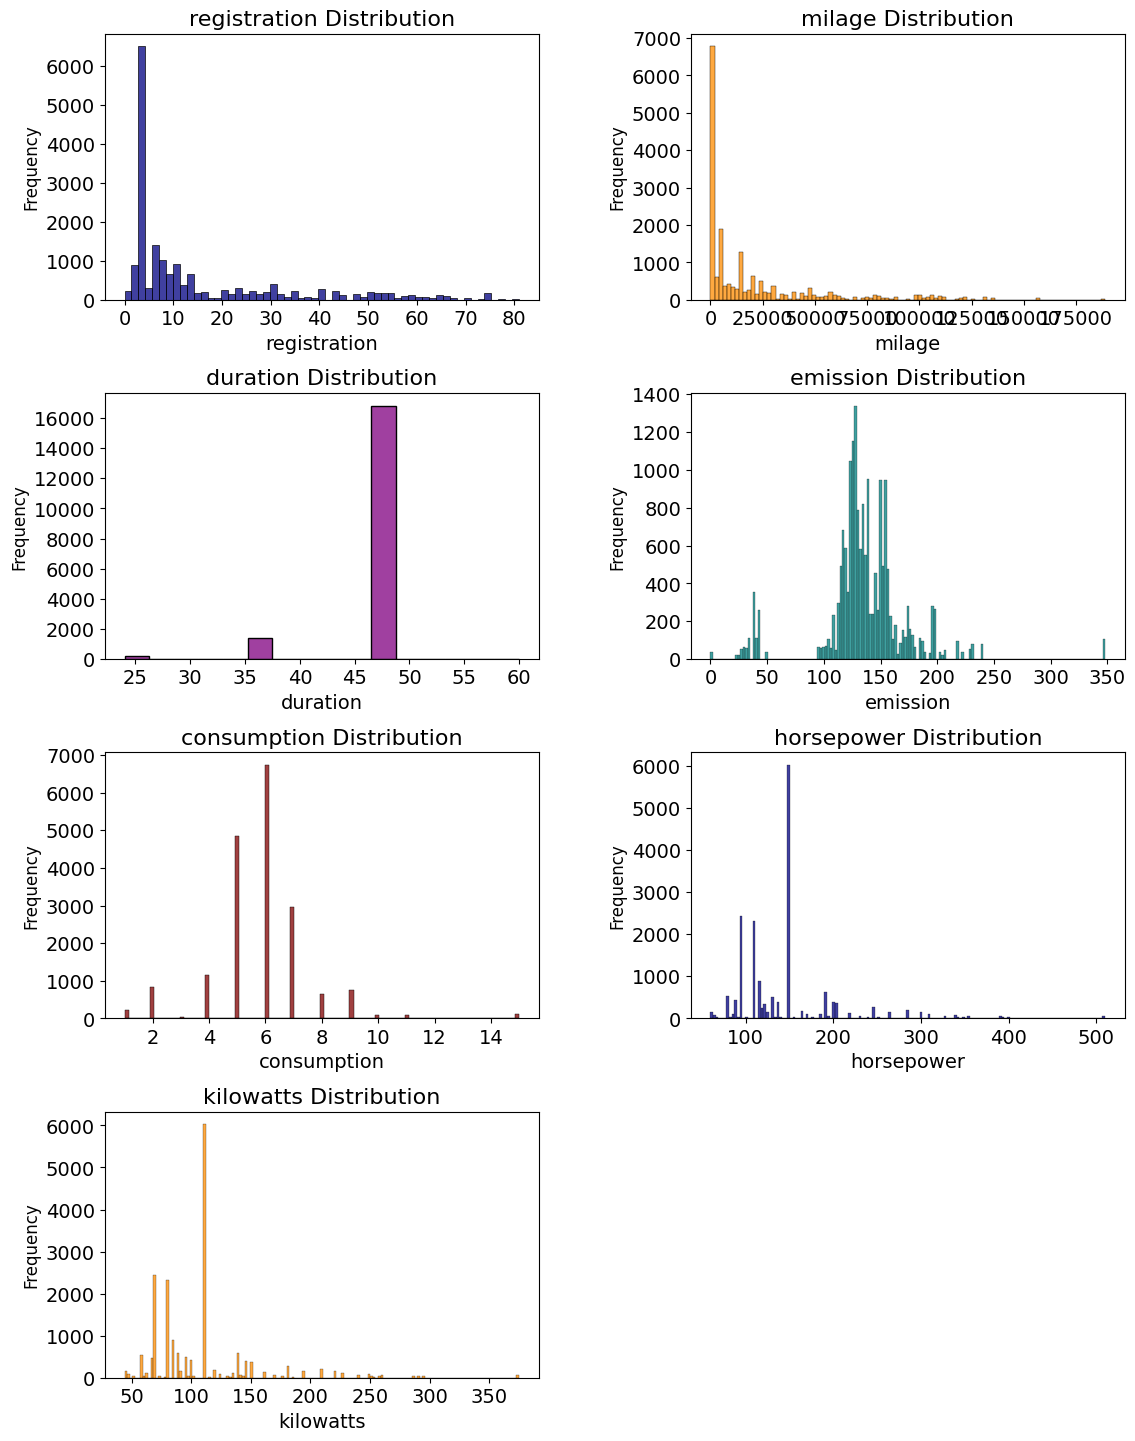

In [14]:
num_FEATURES_hist = num_FEATURES.dropna()

plt.figure(figsize=(12,16))

colors = ['navy', 'darkorange', 'purple', 'teal', 'maroon']

for i, col in enumerate(num_FEATURES_hist.columns):
    idx = int('42' + str(i+1))
    plt.subplot(idx)
    sns.histplot(num_FEATURES_hist[col], color=colors[i % len(colors)])
    plt.title(col+' Distribution', fontsize=16)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(col, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.show()


When examining the skewedness of the numerical variables in our dataset, interesting patterns emerge. Specifically, the registration and mileage variables exhibit right-skewed distributions, indicating a high concentration of new vehicles. This suggests that a significant portion of the dataset comprises recently registered vehicles with relatively low mileage.

In contrast, the emission and consumption variables demonstrate symmetric distributions, implying a more balanced distribution of values. The absence of skewness in these variables suggests that the dataset encompasses a diverse range of emission and consumption values without a pronounced bias towards higher or lower values.
 

### 5.3 Categporical Features <a id="categorical-features"></a>

In [15]:
cat_FEATURES

brand                              model                gear   
0           Skoda  Octavia ŠKODA Combi Style TDI DSG           Automatik  \
1      Volkswagen                T-Cross VW Life TSI  Manuelle Schaltung   
2            Seat              Ibiza Austria Edition  Manuelle Schaltung   
3      Volkswagen                            Polo VW  Manuelle Schaltung   
4            Audi     A4 Avant 40 TDI quattro S line           Automatik   
...           ...                                ...                 ...   
19053        Seat        Ateca FR 2.0 TDI DSG 4Drive           Automatik   
19054       Skoda  Octavia ŠKODA Combi Style TDI DSG           Automatik   
19055        Audi     A4 Avant 40 TDI quattro S line           Automatik   
19056  Volkswagen                            Polo VW  Manuelle Schaltung   
19057  Volkswagen                 Tiguan VW Life TDI  Manuelle Schaltung   

         fuel  
0      Diesel  
1      Benzin  
2      Benzin  
3      Benzin  
4      Diesel  
...       ...  
19053  Diesel  
19054  Diesel  
19055  Diesel  
19056  Benzin  
19057  Diesel  

[19058 rows x 4 columns]

Text(0.5, 1.0, 'Gear Frequencies')

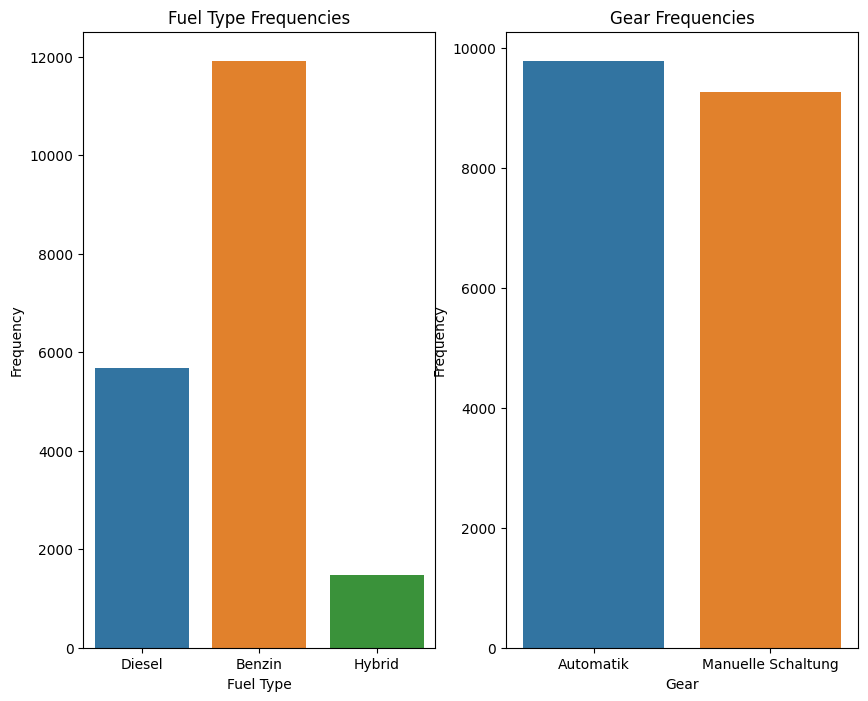

In [16]:
# Create subplots for each categorical variable

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 8))

# Fuel type barplot
sns.countplot(x='fuel', data=cat_FEATURES, ax=axs[0])
axs[0].set_xlabel('Fuel Type')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Fuel Type Frequencies')

# Gear barplot
sns.countplot(x='gear', data=cat_FEATURES, ax=axs[1])
axs[1].set_xlabel('Gear')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Gear Frequencies')

The barplots provide insights into the fuel types and gear types of the vehicles in our dataset. We can observe that the dataset comprises three primary fuel types: diesel, gasoline, and hybrid vehicles. Additionally, the barplots reveal the presence of two gear types: automatic and manual shifts. This highlights the transmission options available within the datase

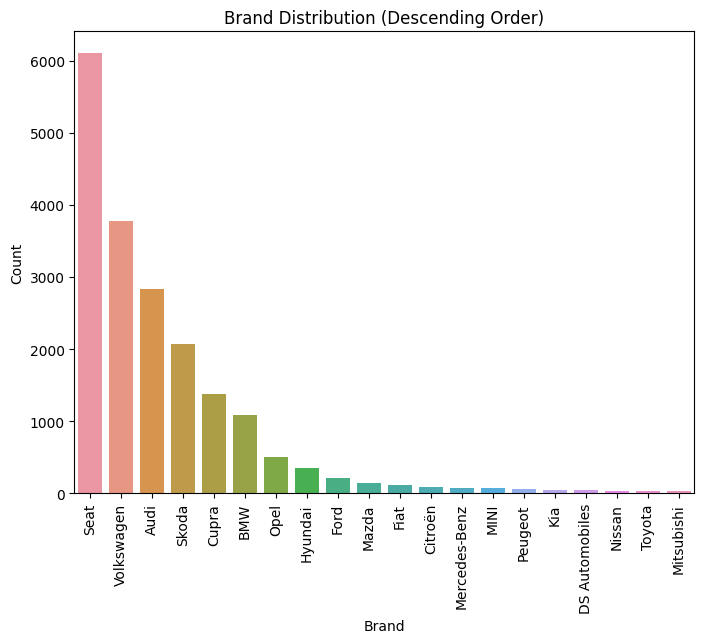

In [17]:
# Distribution of brands
brand_counts = df['brand'].value_counts()

brand_counts = brand_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='brand', order=brand_counts.index)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Brand Distribution (Descending Order)')
plt.xticks(rotation=90)
plt.show()




Upon exploring the brands present in our dataset, we identified several notable findings. The most frequently occurring brands among the vehicles in our dataset are Seat, Volkswagen, Audi, Skoda, Cupra, BMW, and Opel.

The inclusion of these brands in our dataset represents a mix of mainstream vehicles, providing a comprehensive view of the market and enabling us to analyze the impact of brand types on the monthly leasing fees.

### 5.4 Target variable vs. categorical features <a id="target-cat"></a>

<Figure size 2500x600 with 0 Axes>

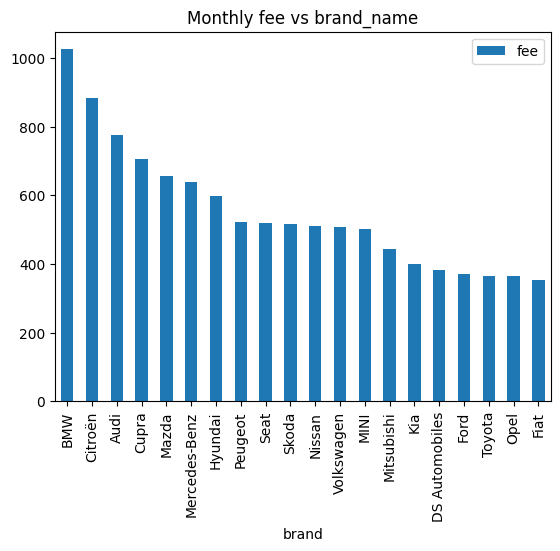

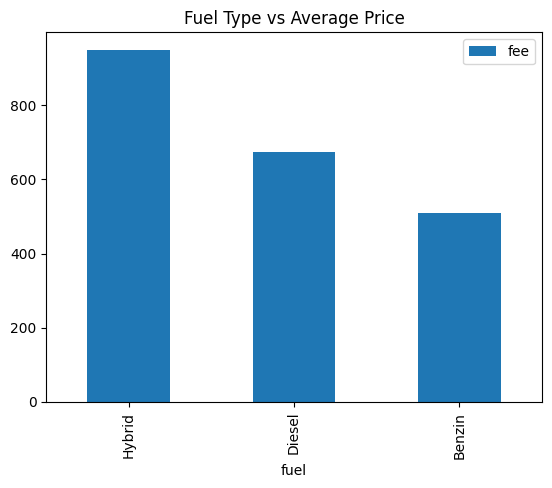

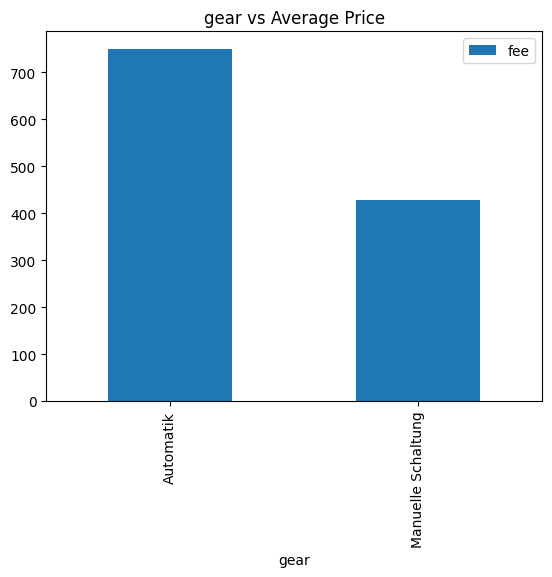

In [18]:
plt.figure(figsize=(25, 6))

df_brand = pd.DataFrame(df.groupby(['brand'])['fee'].mean().sort_values(ascending = False))
df_brand.plot.bar()
plt.title('Monthly fee vs brand_name')
plt.show()

df_fueltype = pd.DataFrame(df.groupby(['fuel'])['fee'].mean().sort_values(ascending = False))
df_fueltype.plot.bar()
plt.title('Fuel Type vs Average Price')
plt.show()

df_gear = pd.DataFrame(df.groupby(['gear'])['fee'].mean().sort_values(ascending = False))
df_gear.plot.bar()
plt.title('gear vs Average Price')
plt.show()

In [ ]:
### 10 most expensive models in our dataset

Analyzing the relationship between the target variable and the categorical variables in our dataset revealed interesting insights. Plotting the target variable against different categorical variables allowed us to examine their impact on leasing rates.

From the visualizations, we observed that BMW models, Citroën, and Audi tend to have higher average leasing prices compared to other brands. **** COULD BE A REASON BECAUSE THE MOST EXPENSIVE MODEL IS A BMW

Moreover, when considering the fuel type, we found that hybrid vehicles tend to have higher monthly fees compared to gasoline or diesel vehicles. This is  attributed to the increased cost of hybrid technology and the potential for fuel savings over time.

Additionally, we observed that automatic cars´ are generally more expensive to lease compared to cars with manual shifting. This is very likely perceived convenience and comfort associated with automatic transmission, which can contribute to higher demand and pricing. 

### 5.5 Heatmap (Correlations) <a id="heatmap"></a>

In [19]:
num_FEATURES

registration    milage  duration  emission  consumption  horsepower   
0                 2     201.0      48.0     119.0          5.0       150.0  \
1                 2     201.0      48.0     131.0          6.0        95.0   
2                 7   15000.0      48.0     120.0          5.0        80.0   
3                 4       1.0      48.0     127.0          6.0        80.0   
4                41  105301.0      48.0     138.0          5.0       190.0   
...             ...       ...       ...       ...          ...         ...   
19053             4     201.0      48.0     146.0          6.0       150.0   
19054             2     201.0      48.0     187.0          8.0       150.0   
19055            41  105301.0      48.0     143.0          6.0       190.0   
19056            35   18903.0      48.0      40.0          2.0        80.0   
19057             8   48000.0      48.0     185.0          8.0       122.0   

       kilowatts  
0          110.0  
1           70.0  
2           59.0  
3           59.0  
4          140.0  
...          ...  
19053      110.0  
19054      110.0  
19055      140.0  
19056       59.0  
19057       90.0  

[19058 rows x 7 columns]

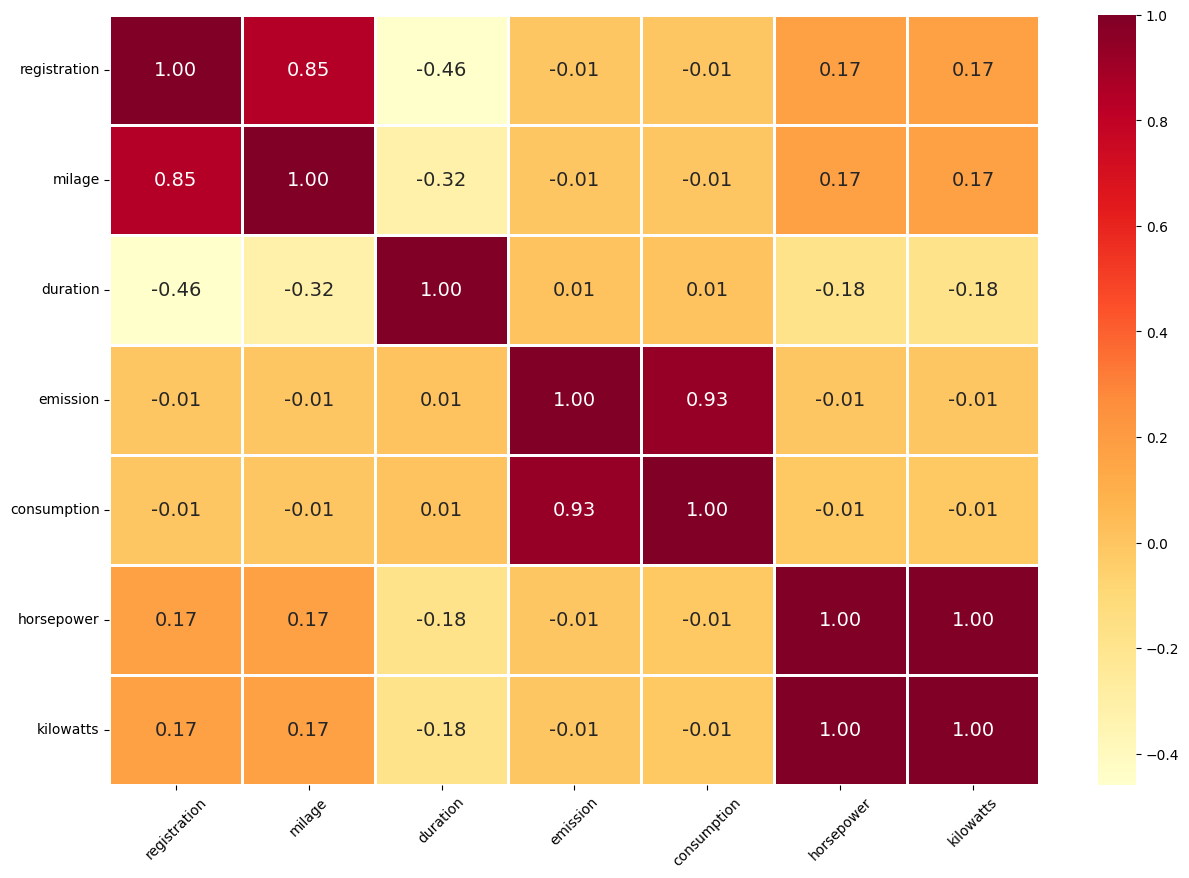

In [20]:
num_corr = num_FEATURES.corr()

# setting figure size
plt.figure(figsize=(15, 10))

# heatmap
sns.heatmap(num_corr, annot=True, linewidths=1.01, fmt=".2f", annot_kws={"size": 14}, linecolor='white', cmap="YlOrRd")

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [1]:
### TARGET VARIABLE

#### 5.5.1 Dropping kilowatts <a id="drop-kilowatts"></a>

In [21]:
df = df.drop('kilowatts', axis = 1)
num_FEATURES = num_FEATURES.drop("kilowatts", axis=1)
FEATURE_names = FEATURE_names.drop("kilowatts")

## 6. Preprocessing and Feature Engineering <a id="preprocessing"></a>

### 6.1 Missing Values<a id="missing-values"></a>


In [22]:
missing_values = df.isnull().sum()

print("Summary of Missing Values:")
print(missing_values)

Summary of Missing Values:
registration      0
milage            0
duration          0
fee               0
emission        612
consumption     612
horsepower        0
brand             0
model             0
gear              0
fuel              0
dtype: int64


### 6.2 Cardinality of non-numeric features<a id="cardinality"></a>

In [23]:
unique_counts = cat_FEATURES.nunique()
print(unique_counts)

brand     20
model    346
gear       2
fuel       3
dtype: int64


### 6.3 Problems with splitting -- STILL OPEN <a id="splitting-problem"></a>

When splitting the dataset by using "train_test_split" we need to use stratification so that one-hot encoding works.
This creates the problem, that entries of the model column, that exist only once OR Twice can not be splitted using stratify. We have three possible approaches:
- drop once or twice appearing single entries of "model"
- duplicate or tripple once or twice appreaing entries of "model"
- create combined category for those models
- **use a custom splitting algorithm**

for now we desided to drop those entries -> Do other approach later!!!!

In [24]:
old_shape = df.shape[0]

In [25]:
few_instances_model = df.groupby("model").filter(lambda x: len(x) < 3)["model"].unique()
df=df[~df["model"].isin(few_instances_model)]
print("Models dropped:", old_shape-df.shape[0])

Models dropped: 19


In [26]:
df

registration    milage  duration     fee  emission  consumption   
0                 2     201.0      48.0  574.01     119.0          5.0  \
1                 2     201.0      48.0  382.58     131.0          6.0   
2                 7   15000.0      48.0  239.62     120.0          5.0   
3                 4       1.0      48.0  309.11     127.0          6.0   
4                41  105301.0      48.0  587.75     138.0          5.0   
...             ...       ...       ...     ...       ...          ...   
19053             4     201.0      48.0  692.03     146.0          6.0   
19054             2     201.0      48.0  574.01     187.0          8.0   
19055            41  105301.0      48.0  587.75     143.0          6.0   
19056            35   18903.0      48.0  256.33      40.0          2.0   
19057             8   48000.0      48.0  539.72     185.0          8.0   

       horsepower       brand                              model   
0           150.0       Skoda  Octavia ŠKODA Combi Style TDI DSG  \
1            95.0  Volkswagen                T-Cross VW Life TSI   
2            80.0        Seat              Ibiza Austria Edition   
3            80.0  Volkswagen                            Polo VW   
4           190.0        Audi     A4 Avant 40 TDI quattro S line   
...           ...         ...                                ...   
19053       150.0        Seat        Ateca FR 2.0 TDI DSG 4Drive   
19054       150.0       Skoda  Octavia ŠKODA Combi Style TDI DSG   
19055       190.0        Audi     A4 Avant 40 TDI quattro S line   
19056        80.0  Volkswagen                            Polo VW   
19057       122.0  Volkswagen                 Tiguan VW Life TDI   

                     gear    fuel  
0               Automatik  Diesel  
1      Manuelle Schaltung  Benzin  
2      Manuelle Schaltung  Benzin  
3      Manuelle Schaltung  Benzin  
4               Automatik  Diesel  
...                   ...     ...  
19053           Automatik  Diesel  
19054           Automatik  Diesel  
19055           Automatik  Diesel  
19056  Manuelle Schaltung  Benzin  
19057  Manuelle Schaltung  Diesel  

[19039 rows x 11 columns]

In [27]:
df.to_csv("data/preprocessed.csv", index=False)

### 6.4 Out of Sample split <a id="osample-split"></a>

In [28]:
df_sample, df_osample = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df[["model"]])

In [29]:
print("Size of the sample data:",df_sample.shape, "with a mean of: ",df_sample["fee"].mean(),
    "\nSize of out of sample data:",df_osample.shape, "with a mean of: ",df_osample["fee"].mean())

Size of the sample data: (16183, 11) with a mean of:  593.0066569857258 
Size of out of sample data: (2856, 11) with a mean of:  592.3941316526611


### 6.5 Train and Test slpit<a id="train-test-split"></a>

In [30]:
X_sample = df_sample.drop(TARGET_name,axis=1)
Y_sample = df_sample[TARGET_name]

X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.25, random_state=SEED, stratify=X_sample[["model"]])
print("Size of the train data:",X_train.shape,"with a mean fee of:",y_train.mean())
print("Size of the test data:",X_test.shape,"with a mean fee of:",y_test.mean())

Size of the train data: (12137, 10) with a mean fee of: 593.1457435939689
Size of the test data: (4046, 10) with a mean fee of: 592.5894315373208


### 6.6 Transformer Pipelines<a id="transformer-pipelines"></a>

In [31]:
numeric_features = num_FEATURES.columns
categorical_features = cat_FEATURES.columns

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='error', sparse_output=False, drop = 'first'))])

preprocessor = ColumnTransformer(
    transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)    
    ])

preprocessor.fit(X_train)

cat_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
columns_pipeline = np.append(cat_columns, numeric_features)

## 7 Machine Learning Modeling<a id="machine-learning-modeling"></a>

### 7.1 Choosing appropriate metric & customization approach <a id="metric"></a>

For evaluation we chose a number of measurements:
- MSE: Mean-Square-Error
- RMSE: Root-Mean-Square-Error (for easier interpretation)
- R-squared (R²)
- Adjusted R-squared
- MAPE: Mean Absolute Percentage Error
- EVS: Explained variance score

#### Monitoring helper function

In [33]:
def monitor_system():
    while monitoring:
        cpu_usage = psutil.cpu_percent()
        memory_usage = psutil.virtual_memory()
        print(f"CPU usage: {cpu_usage}%")
        print(f"Memory usage: {memory_usage}%")

        time.sleep(10)  # Sleep

In [34]:
if compute:
    if comp_effort == "low":
        crossvals = 3
        iterations = 10
        cores = available_cores
    elif comp_effort =="medium":
        crossvals = 5
        iterations = 20
        cores = available_cores-2
    elif comp_effort == "high":
        crossvals = 5
        iterations = 30
        cores = available_cores-2
    else:
        crossvals = 7
        iterations = 50
        cores = available_cores-2


def evaluate(model, X, Y):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(Y, y_pred)
    rmse = mse**0.5
    mae = mean_absolute_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)
    evs = explained_variance_score(Y, y_pred)
    mapr = mean_absolute_percentage_error(Y, y_pred)

    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "EVS": evs,
        "MAPE": mapr
    }
    return (metrics)

# Scoring dictionary
scoring1 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}
scoring2 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}
scoring3 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score),
    'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}
scoring4 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}
scoring = scoring4

### 7.2 Decision Tree <a id="decision-tree"></a>

In [35]:
# Define the parameter distribution
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    param_dist = {
        #'regressor__max_depth': randint(1, 10), # increasing depth always increases score -> overfitting
        'regressor__min_samples_split': [10, 20, 30, 40 ,50, 60, 70],
        'regressor__min_samples_leaf': [2, 4, 8, 10, 15, 20 ,30],
        'regressor__ccp_alpha': uniform(0, 0.1) # search for best ccp_alpha
    }

    # Create a new pipeline with the decision tree regression model
    decisionTree_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", DecisionTreeRegressor())
    ])

    # Perform randomized search with cross-validation
    decisionTree_randomized_search = RandomizedSearchCV(
        decisionTree_pipeline, 
        param_dist, 
        n_iter=3*iterations, 
        cv=2*crossvals, 
        scoring=scoring, 
        refit='MSE', 
        random_state=SEED, 
        n_jobs = cores,
        verbose = 3)
    decisionTree_randomized_search.fit(X_train, y_train)

    # evaluation metrics
    train_metrics = evaluate(decisionTree_randomized_search, X_train, y_train)
    test_metrics = evaluate(decisionTree_randomized_search, X_test, y_test)

    # create a dataframe from metrics
    decisionTree_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(decisionTree_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = decisionTree_randomized_search.best_params_

    decisionTree_params = pd.DataFrame({"Parameters": best_params})
    print(decisionTree_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")



In [36]:
if compute:
    finalTree = DecisionTreeRegressor(
        ccp_alpha = best_params['regressor__ccp_alpha'],
        min_samples_leaf = best_params['regressor__min_samples_leaf'],
        min_samples_split = best_params['regressor__min_samples_split']
    )

    decisionTree_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalTree)
    ])
    decisionTree_final.fit(X_train, y_train)
else:
    decisionTree_final = load(f'{modelfolder}/decisionTree.joblib')

train_metrics = evaluate(decisionTree_final, X_train, y_train)
test_metrics = evaluate(decisionTree_final, X_test, y_test)

# create a dataframe from metrics
decisionTree_metrics = pd.DataFrame({'Decision Tree Train':train_metrics, 'Decision Tree Test': test_metrics})

print("\nEvaluation Metrics:")
print(decisionTree_metrics)


Evaluation Metrics:
      Decision Tree Train  Decision Tree Test
MSE             47.846954           92.090047
RMSE             6.917149            9.596356
MAE              2.546763            3.199086
R2               0.999482            0.999007
EVS              0.999482            0.999009
MAPE             0.004965            0.006206


### 7.3 Random Forest<a id="random-forest"></a>

In [37]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    #param_dist = {
    #    'regressor__n_estimators': randint(20,50),
    #    # 'regressor__max_depth': randint(1,7),
    #    'regressor__min_samples_split': randint(2, 30),
    #    'regressor__min_samples_leaf': randint(1, 100)
    #}

    param_dist = {
        'regressor__n_estimators': [100, 200, 300, 400, 500, 500, 600, 650, 750, 850, 1000],
        'regressor__max_depth': [8, 10, 12, 15, 20, 25, 30, 35, 40, 50, 55, 60, 70],
        'regressor__min_samples_split': [8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
        'regressor__min_samples_leaf': [4, 6, 8, 10, 15, 20, 30, 40, 50],
    }

    rf_randomized_search = RandomizedSearchCV(
        rf_pipeline, 
        param_distributions=param_dist, 
        n_iter = 2*iterations, 
        cv=2*crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        n_jobs = cores,
        verbose = 3)

    rf_randomized_search.fit(X_train, y_train)

    # evaluation metrics
    train_metrics = evaluate(rf_randomized_search, X_train, y_train)
    test_metrics = evaluate(rf_randomized_search, X_test, y_test)

    # create a dataframe from metrics
    randomForest_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(randomForest_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = rf_randomized_search.best_params_

    randomForest_params = pd.DataFrame({"Parameters": best_params})
    print(randomForest_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [38]:
if compute:
    finalForest = RandomForestRegressor(
        n_estimators = 700,#best_params['regressor__n_estimators'], #750
        min_samples_split = 10,#best_params['regressor__min_samples_split'], #10
        min_samples_leaf = 4,#best_params['regressor__min_samples_leaf'], #4
        max_depth = 40#best_params['regressor__max_depth'] #40
    )

    randomForest_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalForest)
    ])
    randomForest_final.fit(X_train, y_train)

else:
    randomForest_final = load(f'{modelfolder}/randomForest.joblib')

train_metrics = evaluate(randomForest_final, X_train, y_train)
test_metrics = evaluate(randomForest_final, X_test, y_test)

# create a dataframe from metrics
randomForest_metrics = pd.DataFrame({'Random Forest Train':train_metrics, 'Random Forest Test': test_metrics})

print("\nEvaluation Metrics:")
print(randomForest_metrics)


Evaluation Metrics:
      Random Forest Train  Random Forest Test
MSE             68.738417          102.152740
RMSE             8.290863           10.107064
MAE              2.964008            3.688731
R2               0.999256            0.998899
EVS              0.999256            0.998900
MAPE             0.005326            0.006764


### 7.4 K-nearest neighbor <a id="k-neighbors"></a>

In [39]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    # Define the KNN pipeline
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor())
    ])

    # Define the parameter distribution for random search
    param_dist = {
        'regressor__n_neighbors': randint(5,100),
        'regressor__leaf_size': randint(30,100),
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1,2]  # 1 for Manhattan distance, 2 for Euclidean distance
    }

    # Perform random search for hyperparameter tuning
    knn_randomized_search = RandomizedSearchCV(
        knn_pipeline,
        param_distributions=param_dist,
        n_iter=iterations,
        cv=2*crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state = SEED,
        n_jobs = cores,
        verbose = 3
    )

    # Fit the KNN model to the training data
    knn_randomized_search.fit(X_train, y_train)

    # Evaluate the model performance
    train_metrics = evaluate(knn_randomized_search, X_train, y_train)
    test_metrics = evaluate(knn_randomized_search, X_test, y_test)

    # Create a dataframe from metrics
    knn_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(knn_metrics)

    # Get the best hyperparameter values and model performance
    best_params = knn_randomized_search.best_params_
    knn_params = pd.DataFrame({"Parameters": best_params})
    print(knn_params)

    print("\nEvaluation Metrics:")
    print(knn_metrics)
    
    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [40]:
if compute:
    finalKnn = KNeighborsRegressor(
        leaf_size = best_params['regressor__leaf_size'],#33
        n_neighbors = best_params['regressor__n_neighbors'], #8
        weights= best_params['regressor__weights'], #distance
        p = best_params['regressor__p'] #1
    )

    knn_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalKnn)
    ])

    knn_final.fit(X_train, y_train)

else:
    knn_final = load(f'{modelfolder}/KNN.joblib')


train_metrics = evaluate(knn_final, X_train, y_train)
test_metrics = evaluate(knn_final, X_test, y_test)

# create a dataframe from metrics
knn_metrics = pd.DataFrame({'KNN Train':train_metrics, 'KNN Test': test_metrics})

print("\nEvaluation Metrics:")
print(knn_metrics)


Evaluation Metrics:
      KNN Train    KNN Test
MSE   11.755717  502.642432
RMSE   3.428661   22.419688
MAE    0.703240    9.642505
R2     0.999873    0.994581
EVS    0.999873    0.994586
MAPE   0.001378    0.017537


### 7.5 XGB <a id="xgb"></a>

In [41]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    # Define the parameter distribution
    param_dist = {
        'regressor__max_depth': [15, 20, 25, 30, 35, 40, 45, 50 , 55, 60, 65, 70],
        'regressor__learning_rate': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.10, 0.2, 0.3, 0.5],
        'regressor__n_estimators': [125, 150, 160, 175, 185, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500],
        'regressor__gamma': [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55],
        'regressor__subsample': [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8,0.9],
        'regressor__colsample_bytree': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
        'regressor__min_child_weight':randint(1,20),
        'regressor__reg_lambda': [0, 0.001, 0.004, 0.006, 0.01, 0.05, 0.1, 1, 2, 3, 4, 5, 6, 7, 10],
        'regressor__reg_alpha' :[0, 1, 10, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100],
        'regressor__tree_method':["gpu_hist"],
        #'regressor__seed':SEED
    }

    # Create a new pipeline with the XGBoost regressor model
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor())
    ])

    # Perform randomized search with cross-validation
    xgb_randomized_search = RandomizedSearchCV(
        xgb_pipeline,
        param_dist,
        n_iter=4*iterations,
        cv=2*crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=cores,
        verbose = 3)
        
    xgb_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics = evaluate(xgb_randomized_search, X_train, y_train)
    test_metrics = evaluate(xgb_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    xgb_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(xgb_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = xgb_randomized_search.best_params_
    xgb_params = pd.DataFrame({"Parameters": best_params})
    print(xgb_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [42]:
#monitoring = False
#monitoring_thread.join()
#end_time = time.time()  # Record the end time
#computation_time = end_time - start_time
#print(f"Computation time: {computation_time}")

In [43]:
if compute:
    finalXGB = XGBRegressor(
        colsample_bytree = best_params['regressor__colsample_bytree'], #0.65
        gamma = best_params['regressor__gamma'],# 0.05
        learning_rate = best_params['regressor__learning_rate'], #0.02
        max_depth = best_params['regressor__max_depth'], #25
        subsample = best_params['regressor__subsample'], #0.45
        n_estimators = best_params['regressor__n_estimators'],
        min_child_weight = best_params['regressor__min_child_weight'],
        reg_alpha = best_params['regressor__reg_alpha'],
        reg_lambda = best_params['regressor__reg_lambda'],
        tree_method = best_params['regressor__tree_method'],
    )

    xgb_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalXGB)
    ])
    xgb_final.fit(X_train, y_train)

else:
    xgb_final = load(f'{modelfolder}/XGBoost.joblib')

train_metrics = evaluate(xgb_final, X_train, y_train)
test_metrics = evaluate(xgb_final, X_test, y_test)

# Create a DataFrame from metrics
xgb_metrics = pd.DataFrame({'XGB Train': train_metrics, 'XGB Test': test_metrics})

print("\nEvaluation Metrics:")
print(xgb_metrics)


Evaluation Metrics:
      XGB Train   XGB Test
MSE   30.026445  65.719158
RMSE   5.479639   8.106735
MAE    2.533013   3.429232
R2     0.999675   0.999291
EVS    0.999675   0.999292
MAPE   0.004893   0.006648


In [44]:
print(xgb_final["regressor"].get_xgb_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.75, 'eval_metric': None, 'gamma': 0.35, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.06, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 50, 'max_leaves': None, 'min_child_weight': 2, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 30, 'reg_lambda': 0.01, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


### 7.6 Support-Vector-Machines (SVM) <a id="svm"></a>

In [45]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ])

    param_dist = {
        'regressor__C': [0.1, 0.5, 1, 5, 10, 20, 30, 50, 75, 100, 200],
        'regressor__kernel': ['linear', 'rbf', 'poly'],
        'regressor__epsilon': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1],
    }
    svm_randomized_search = RandomizedSearchCV(
        svm_pipeline,
        param_distributions=param_dist,
        n_iter=iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=cores,
        verbose = 3
    )

    svm_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics = evaluate(svm_randomized_search, X_train, y_train)
    test_metrics = evaluate(svm_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    svm_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(svm_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = svm_randomized_search.best_params_
    svm_params = pd.DataFrame({"Parameters": best_params})
    print(svm_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

In [46]:
if compute:
    finalSVM = SVR(
        C=best_params['regressor__C'],
        kernel=best_params['regressor__kernel'],
        epsilon=best_params['regressor__epsilon']
    )

    svm_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalSVM)
    ])
    svm_final.fit(X_train, y_train)

else:
    svm_final = load(f'{modelfolder}/SVM.joblib')

train_metrics = evaluate(svm_final, X_train, y_train)
test_metrics = evaluate(svm_final, X_test, y_test)

# Create a DataFrame from metrics
svm_metrics = pd.DataFrame({'SVM Train': train_metrics, 'SVM Test': test_metrics})

print("\nEvaluation Metrics:")
print(svm_metrics)



Evaluation Metrics:
        SVM Train     SVM Test
MSE   1102.581547  1199.509864
RMSE    33.205143    34.633941
MAE     13.251504    14.137656
R2       0.988071     0.987068
EVS      0.988153     0.987173
MAPE     0.023237     0.024949


## 8 Test Data Performance <a id="test-performance"></a>

### 8.1 Metrics comparison <a id="test-metrics-comparison"></a>

In [47]:
metrics = [decisionTree_metrics, randomForest_metrics, knn_metrics, xgb_metrics, svm_metrics]

# Create empty DataFrames for train metrics and test metrics
train_metrics = pd.DataFrame()
test_metrics = pd.DataFrame()

# Loop through the metrics list and assign train and test metrics
for metric in metrics:
    for col in metric.columns:
        if "Train" in col:
            train_metrics = pd.concat([train_metrics, metric[[col]]], axis=1)
        elif "Test" in col:
            test_metrics = pd.concat([test_metrics, metric[[col]]], axis=1)

In [48]:
def plotBars(metrics_input):
    #Define the evaluation metrics and their values
    metrics = metrics_input.index
    models = metrics_input.columns
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']

    # Set the figure size and create subplots
    fig, axs = plt.subplots(len(metrics) // 3, 3, figsize=(15, 6 * (len(metrics) // 3)))

    # Set the width of the bars
    bar_width = 0.25

    # Set the positions of the bars on the x-axis

    test_r = np.arange(len(models))
    # train_r = np.arange(len(models))
    # test_r = [x + bar_width/2 for x in r1]
    # Create a bar plot for each evaluation metric
    for i, metric in enumerate(metrics):
        test_values = None
        test_values = metrics_input.loc[metric].values


        # Check if values exist for all models
        if test_values.any() and len(test_values) == len(models):
            row = i // 3  # Determine the row index
            col = i % 3   # Determine the column index
            
            ax = axs[row, col]  # Get the corresponding subplot
            
            # Create a bar plot for each model with different color
            for j in range(len(test_values)):

                # ax.bar(train_r[j], train_values[j], width=bar_width, edgecolor='black', color=colors[j])
                ax.bar(test_r[j], test_values[j], width=bar_width, edgecolor='black', color=colors[j])
                
            
            # Set the labels, title, and ticks for the subplot
            ax.set_xlabel('Model')
            ax.set_ylabel(metric)
            ax.set_title(f'{metric} Comparison')
            ax.set_xticks(test_r)
            ax.set_xticklabels(models.str.strip(" Test"))

            # Adjust the spacing for long x-axis tick labels
            ax.set_xticks(test_r)
            ax.set_xticklabels(models.str.strip(" Test"), rotation=45, ha='right')
            plt.subplots_adjust(bottom=0.5)  # Increase the bottom margin if needed
            # Rotating the x-axis tick labels by 45 degrees for each subplot
            #ax.tick_params(axis='x', rotation=45)

            # Scale the y-axis to better visualize differences
            max_value = np.max(test_values)
            min_value = np.min(test_values)
            ax.set_ylim([min_value - 0.1 * abs(max_value), max_value + 0.1 * abs(max_value)])

            
        
    # Adjust the spacing between subplots
    plt.tight_layout()



    # Show the plot
    plt.show()

In [49]:
def plotPvA(model, name, X, y):
    y_pred = model.predict(X)
    fig, axs = plt.subplots(ncols=2, figsize=(15, 8))

    # Increase default font size
    plt.rcParams.update({'font.size': 14})

    # Define the prediction error display for actual vs. predicted
    pred_err_disp1 = PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=500,
        ax=axs[0],
        random_state=0,
    )

    # Add gridlines, labels and title
    axs[0].grid(True)
    axs[0].set_xlabel('Predicted values')
    axs[0].set_ylabel('Actual values')
    axs[0].set_title("Actual vs. Predicted values")

    # Set the axis scale to log
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # Define the prediction error display for residuals vs. predicted
    pred_err_disp2 = PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=500,
        ax=axs[1],
        random_state=0,
    )

    # Add gridlines, labels and title
    axs[1].grid(True)
    axs[1].set_xlabel('Predicted values')
    axs[1].set_ylabel('Residuals')
    axs[1].set_title("Residuals vs. Predicted Values")


    # Set the main title and layout
    fig.suptitle(f"Plotting cross-validated predictions of {name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    residuals = (y - y_pred)
    print(f"The mean residual of {name} is:", np.mean(residuals))

In [50]:
train_metrics


Decision Tree Train  Random Forest Train  KNN Train  XGB Train   
MSE             47.846954            68.738417  11.755717  30.026445  \
RMSE             6.917149             8.290863   3.428661   5.479639   
MAE              2.546763             2.964008   0.703240   2.533013   
R2               0.999482             0.999256   0.999873   0.999675   
EVS              0.999482             0.999256   0.999873   0.999675   
MAPE             0.004965             0.005326   0.001378   0.004893   

        SVM Train  
MSE   1102.581547  
RMSE    33.205143  
MAE     13.251504  
R2       0.988071  
EVS      0.988153  
MAPE     0.023237

In [51]:
test_metrics

Decision Tree Test  Random Forest Test    KNN Test   XGB Test   
MSE            92.090047          102.152740  502.642432  65.719158  \
RMSE            9.596356           10.107064   22.419688   8.106735   
MAE             3.199086            3.688731    9.642505   3.429232   
R2              0.999007            0.998899    0.994581   0.999291   
EVS             0.999009            0.998900    0.994586   0.999292   
MAPE            0.006206            0.006764    0.017537   0.006648   

         SVM Test  
MSE   1199.509864  
RMSE    34.633941  
MAE     14.137656  
R2       0.987068  
EVS      0.987173  
MAPE     0.024949

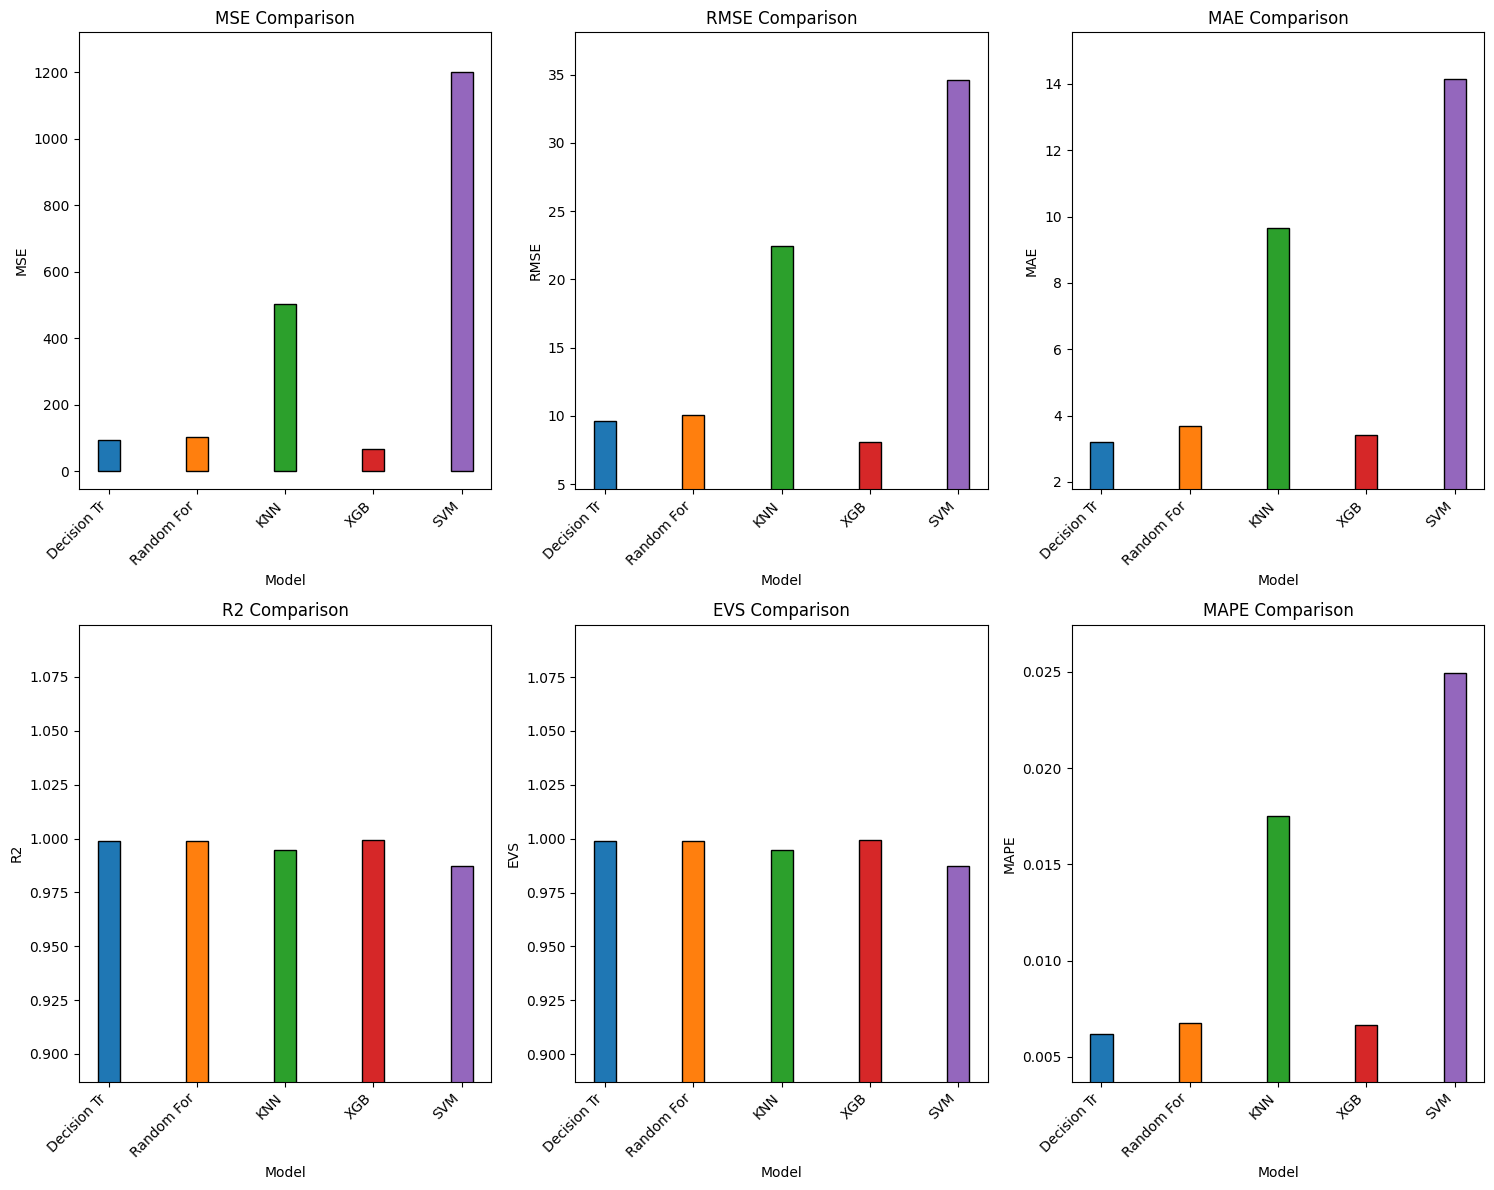

In [52]:
plotBars(test_metrics)

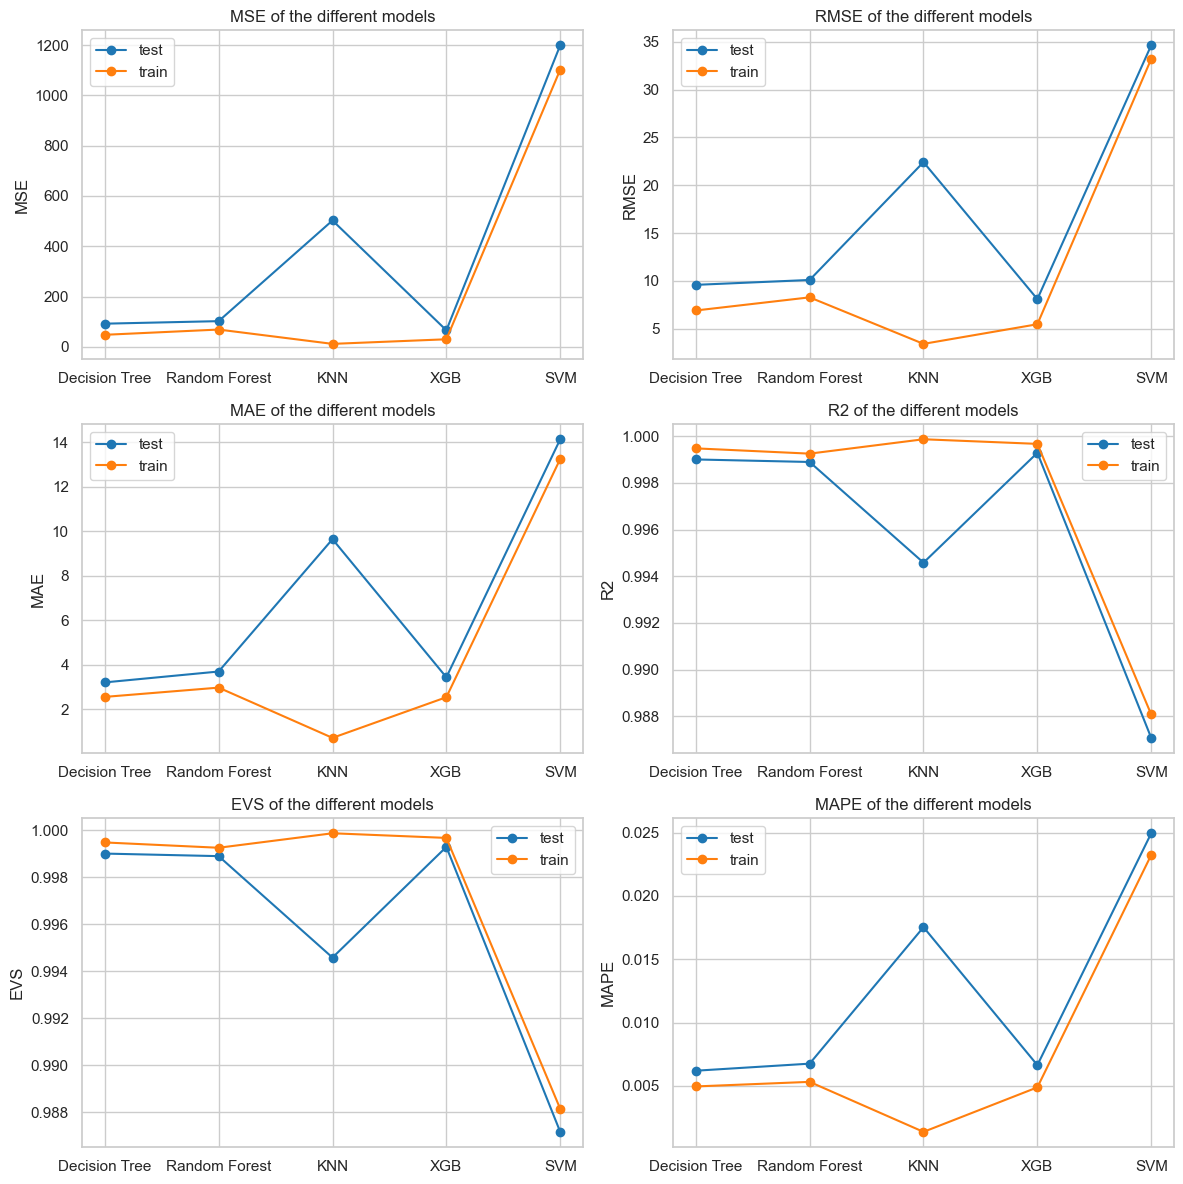

In [53]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e']

# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = test_metrics.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(test_metrics.columns.str.replace(" Test",""), test_metrics.iloc[i], label="test", marker='o', color=colors[0])
    plt.plot(train_metrics.columns.str.replace(" Train",""), train_metrics.iloc[i], label="train", marker='o', color=colors[1])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### 8.2 Predicted vs actual plots <a id="test-predicted-actual"></a>

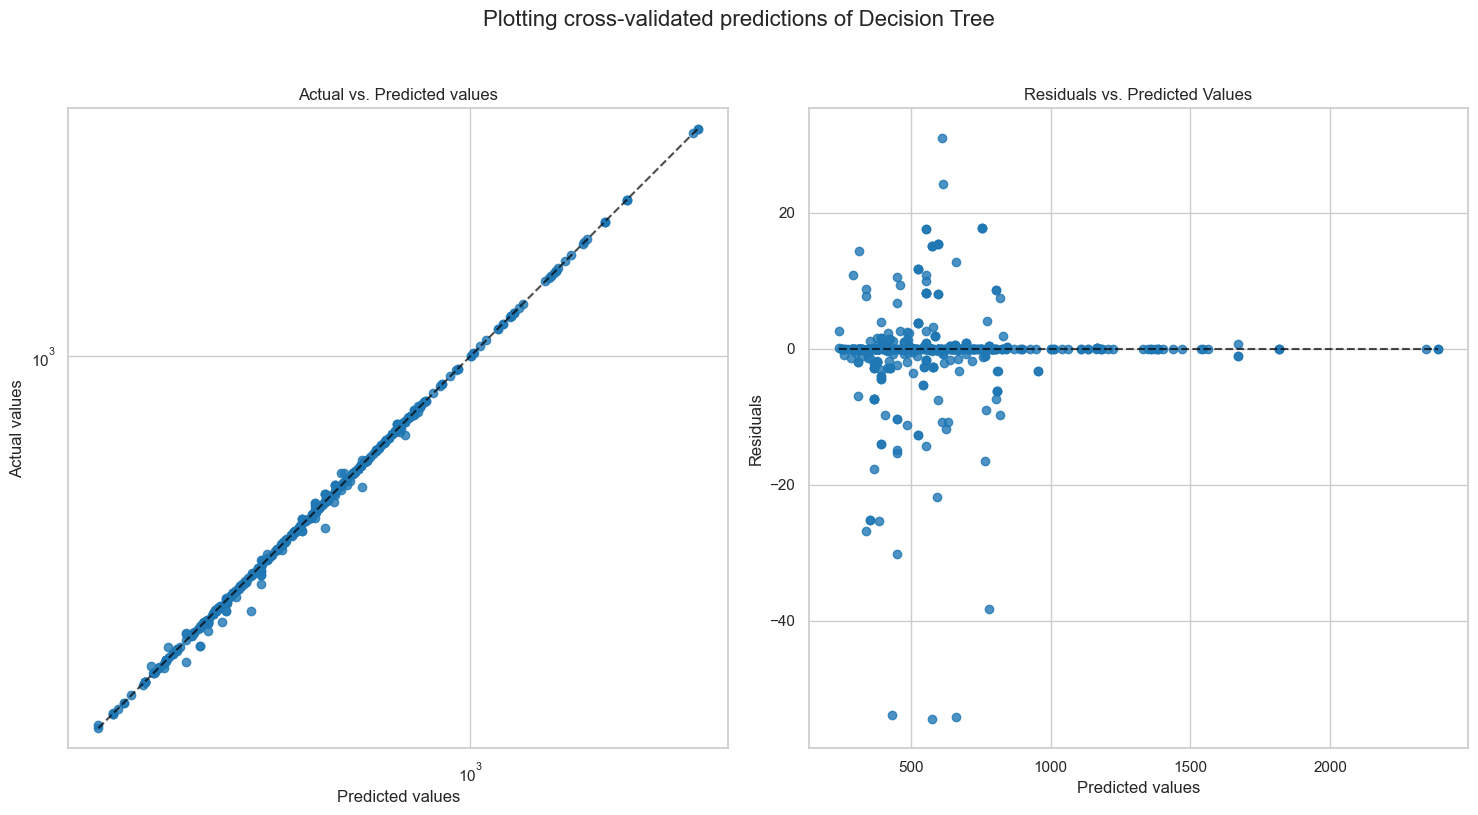

The mean residual of Decision Tree is: 0.37672952907824053


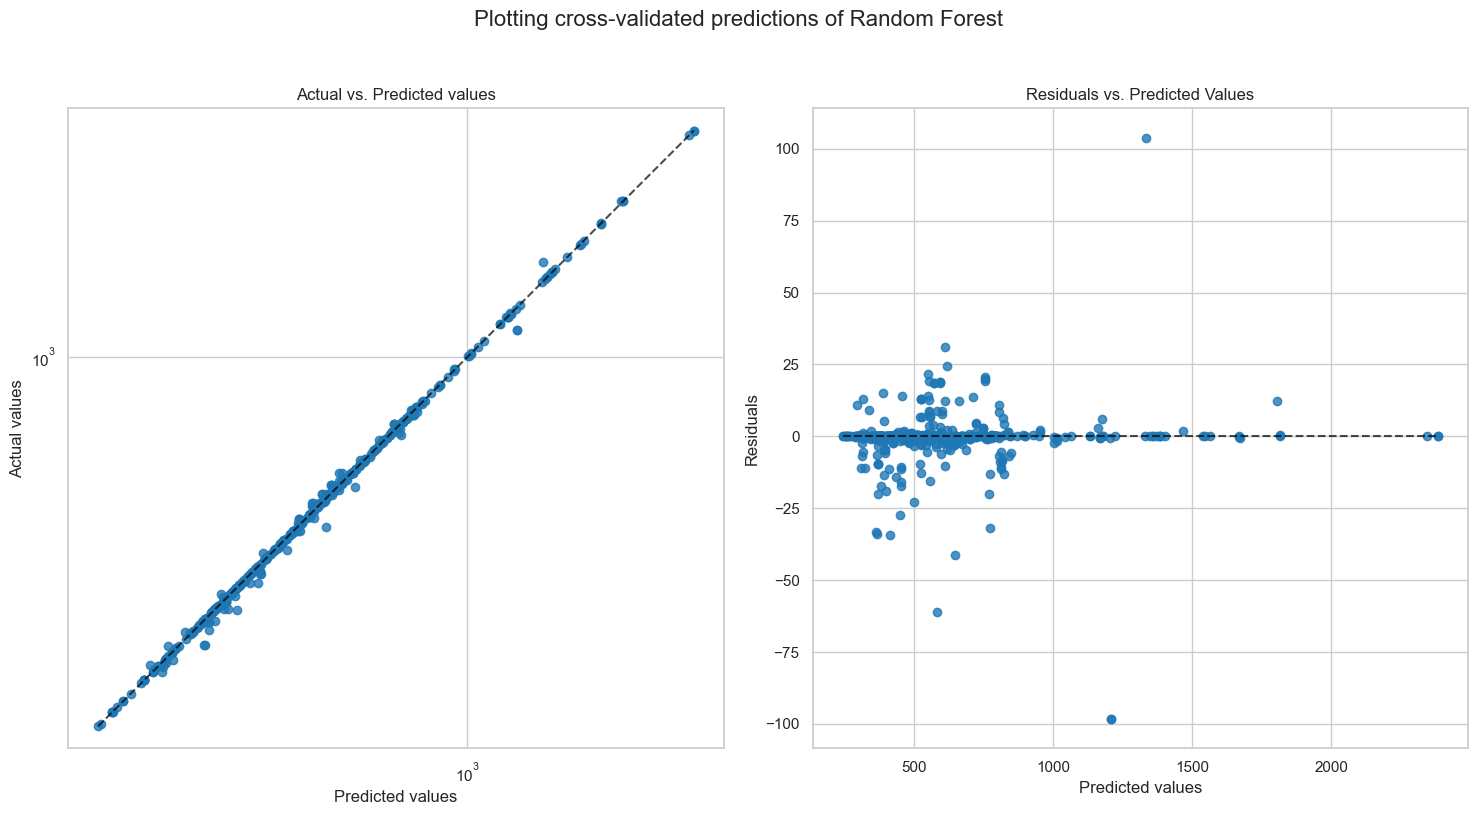

The mean residual of Random Forest is: 0.33773057287322555


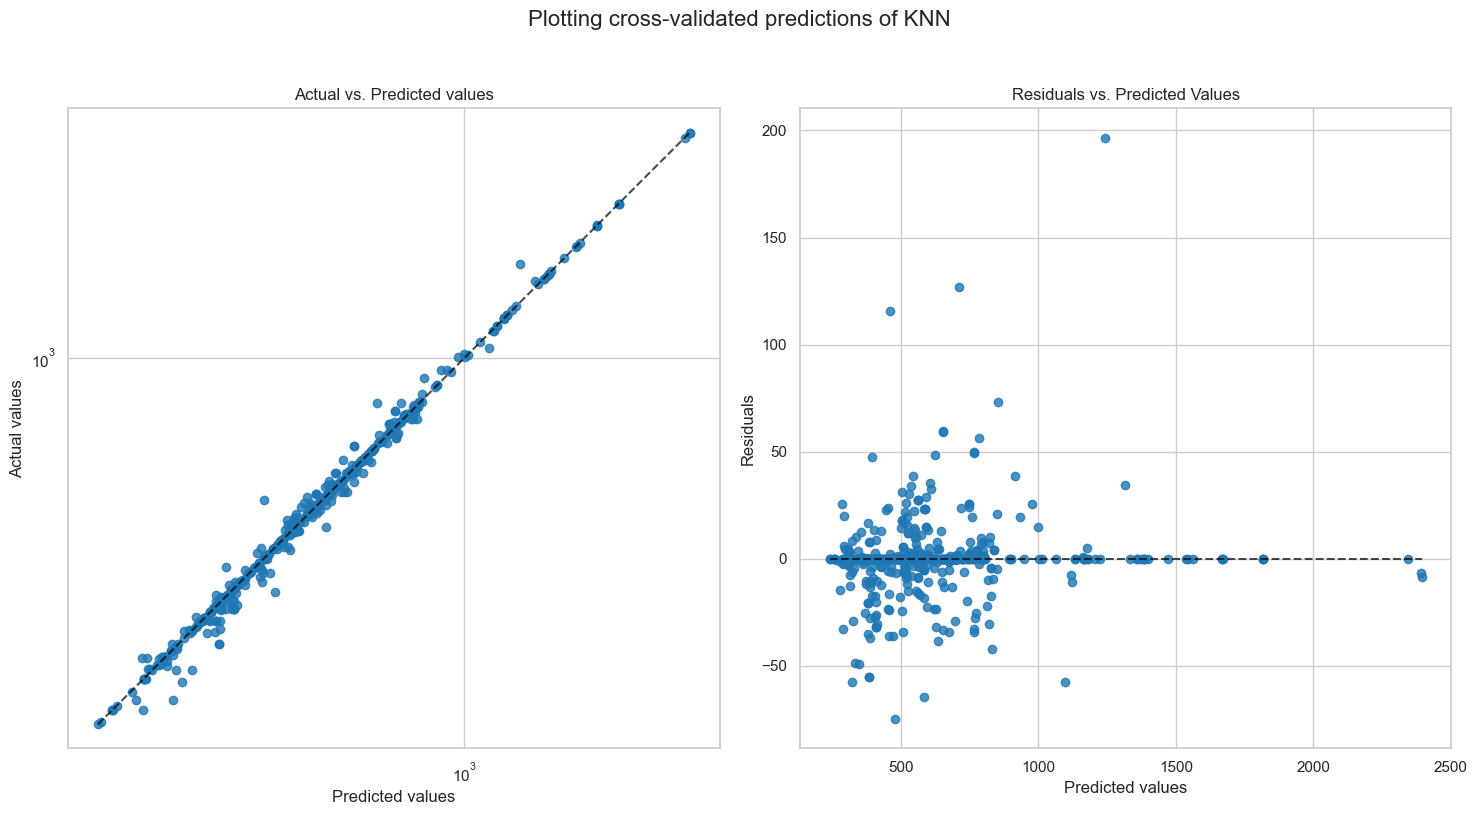

The mean residual of KNN is: 0.6483851179648926


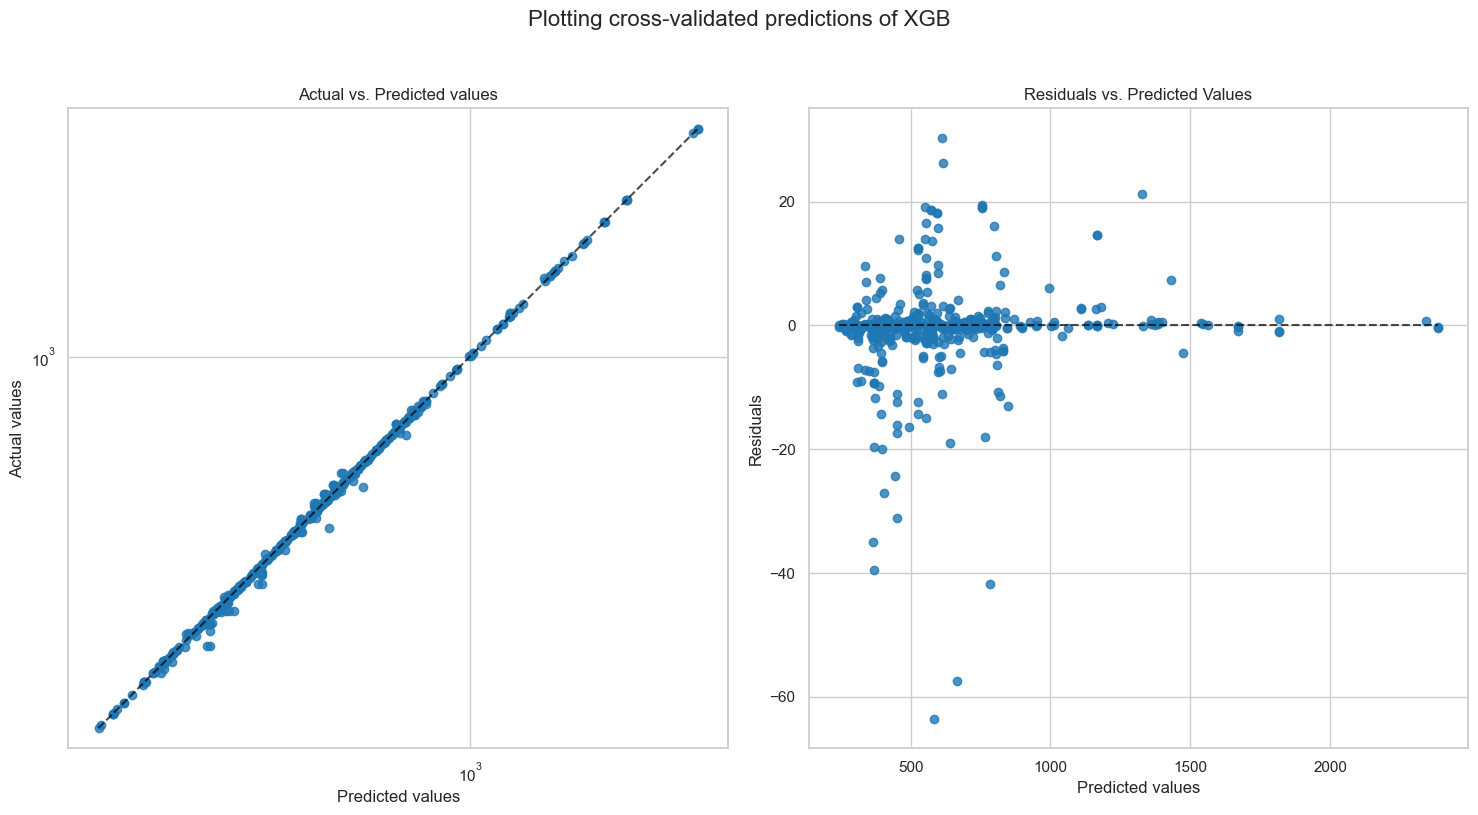

The mean residual of XGB is: 0.2992008650096656


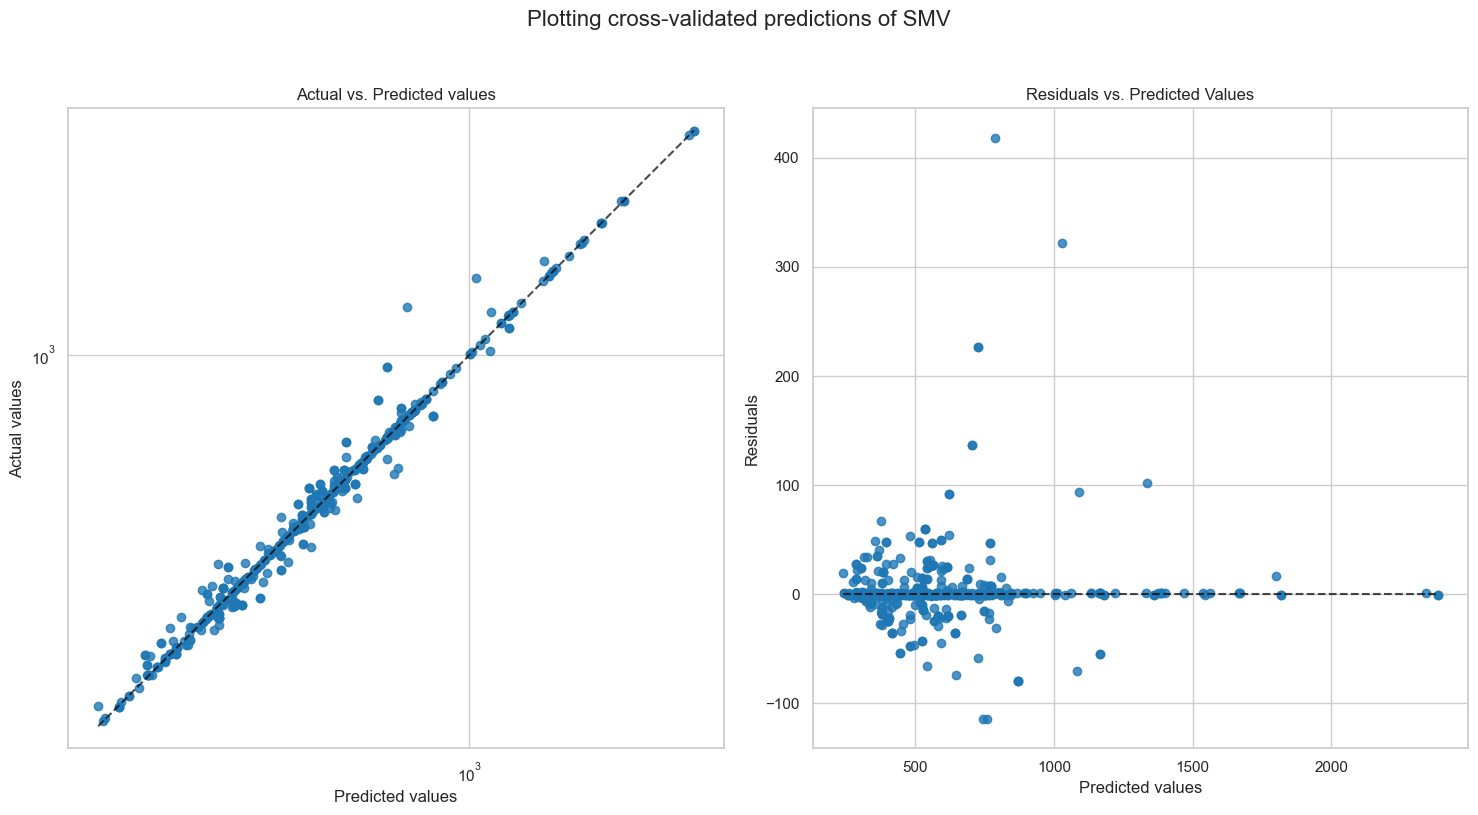

The mean residual of SMV is: 3.115974751089612


In [54]:
plotPvA(decisionTree_final, "Decision Tree", X_test, y_test)
plotPvA(randomForest_final, "Random Forest", X_test, y_test)
plotPvA(knn_final, "KNN", X_test, y_test)
plotPvA(xgb_final, "XGB", X_test, y_test)
plotPvA(svm_final, "SMV", X_test, y_test)

### 8.3 Histogram of residuals <a id="test-histograms"></a>

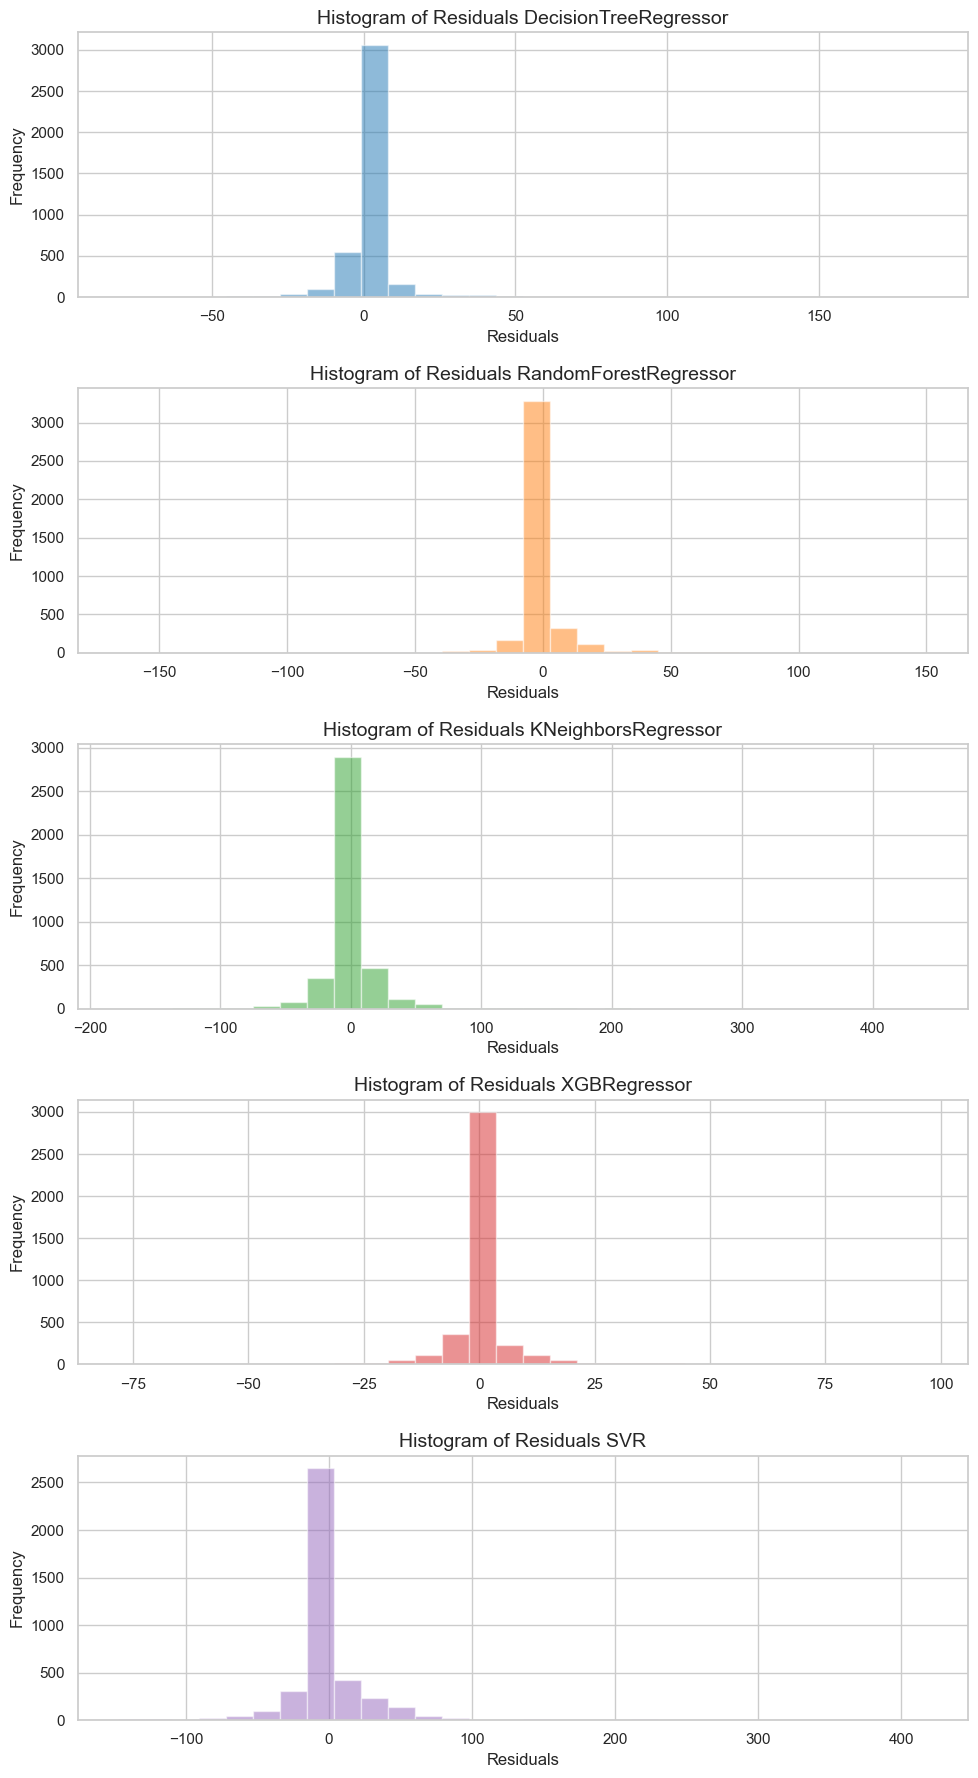

In [55]:
def plotResiduals(models,X,y):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']
# Obtain the predictions of the models
    predictions =[]
    residuals=[]
    for model in models:
        #compute predictions
        prediction = model.predict(X)
        predictions.append(prediction)
        #append residuals
        residuals.append(y - prediction)

    fig, axs = plt.subplots(len(models), 1, figsize=(10, 18))

    for i,model in enumerate(models):
        axs[i].hist(residuals[i], bins=30, color=colors[i], alpha=0.5)
        axs[i].set_title(f'Histogram of Residuals {model.steps[-1][1].__class__.__name__}', fontsize=14)
        axs[i].set_xlabel('Residuals', fontsize=12)
        axs[i].set_ylabel('Frequency', fontsize=12)

    fig.tight_layout()
    plt.show()

models=[decisionTree_final, randomForest_final, knn_final, xgb_final, svm_final]

plotResiduals(models,X_test,y_test)

## 9 Out of sample performance <a id="osample-performance"></a>

### 9.1 Metrics comparison <a id="osample-metrics-comparison"></a>

In [56]:
X_osample = df_osample.drop(TARGET_name,axis=1)
y_osample = df_osample[TARGET_name]

In [57]:
a= pd.DataFrame({"asdf":evaluate(decisionTree_final, X_osample, y_osample)})

In [58]:
test_metrics

Decision Tree Test  Random Forest Test    KNN Test   XGB Test   
MSE            92.090047          102.152740  502.642432  65.719158  \
RMSE            9.596356           10.107064   22.419688   8.106735   
MAE             3.199086            3.688731    9.642505   3.429232   
R2              0.999007            0.998899    0.994581   0.999291   
EVS             0.999009            0.998900    0.994586   0.999292   
MAPE            0.006206            0.006764    0.017537   0.006648   

         SVM Test  
MSE   1199.509864  
RMSE    34.633941  
MAE     14.137656  
R2       0.987068  
EVS      0.987173  
MAPE     0.024949

In [59]:
def getMetrics(model,name, X,y):
    metrics = evaluate(model, X, y)
    metrics = pd.DataFrame({name:metrics})
    metrics = metrics.reindex(test_metrics.index)
    return(metrics)

decisionTree_osample_metrics = getMetrics(decisionTree_final, "Decision Tree out of sample", X_osample, y_osample)
randomForest_osample_metrics = getMetrics(randomForest_final, "Random Forest out of sample", X_osample, y_osample)
knn_osample_metrics = getMetrics(knn_final, "KNN out of sample", X_osample, y_osample)
xgb_osample_metrics = getMetrics(xgb_final,"XGB out of sample", X_osample, y_osample)
svm_osample_metrics = getMetrics(svm_final,"SVM out of sample", X_osample, y_osample)

In [60]:
osample_metrics = pd.concat([decisionTree_osample_metrics,
                            randomForest_osample_metrics,
                            knn_osample_metrics,
                            xgb_osample_metrics,
                            svm_osample_metrics],
                            axis=1)

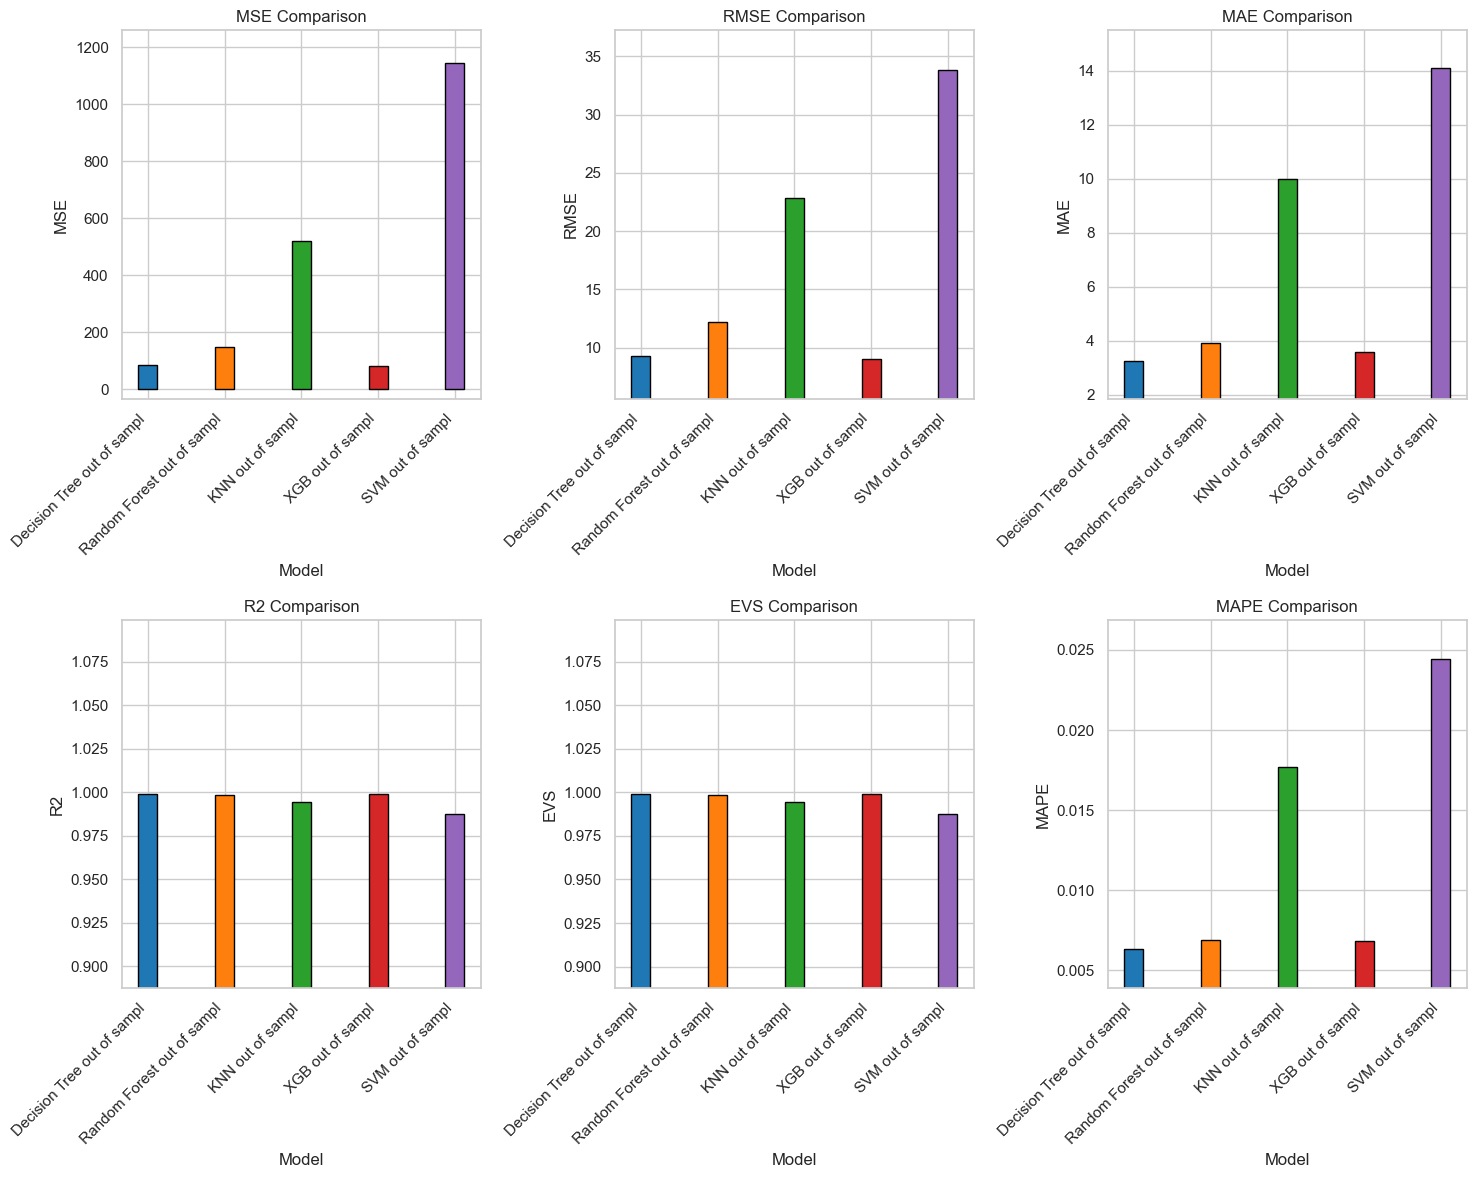

In [61]:
plotBars(osample_metrics)

In [62]:
test_metrics

Decision Tree Test  Random Forest Test    KNN Test   XGB Test   
MSE            92.090047          102.152740  502.642432  65.719158  \
RMSE            9.596356           10.107064   22.419688   8.106735   
MAE             3.199086            3.688731    9.642505   3.429232   
R2              0.999007            0.998899    0.994581   0.999291   
EVS             0.999009            0.998900    0.994586   0.999292   
MAPE            0.006206            0.006764    0.017537   0.006648   

         SVM Test  
MSE   1199.509864  
RMSE    34.633941  
MAE     14.137656  
R2       0.987068  
EVS      0.987173  
MAPE     0.024949

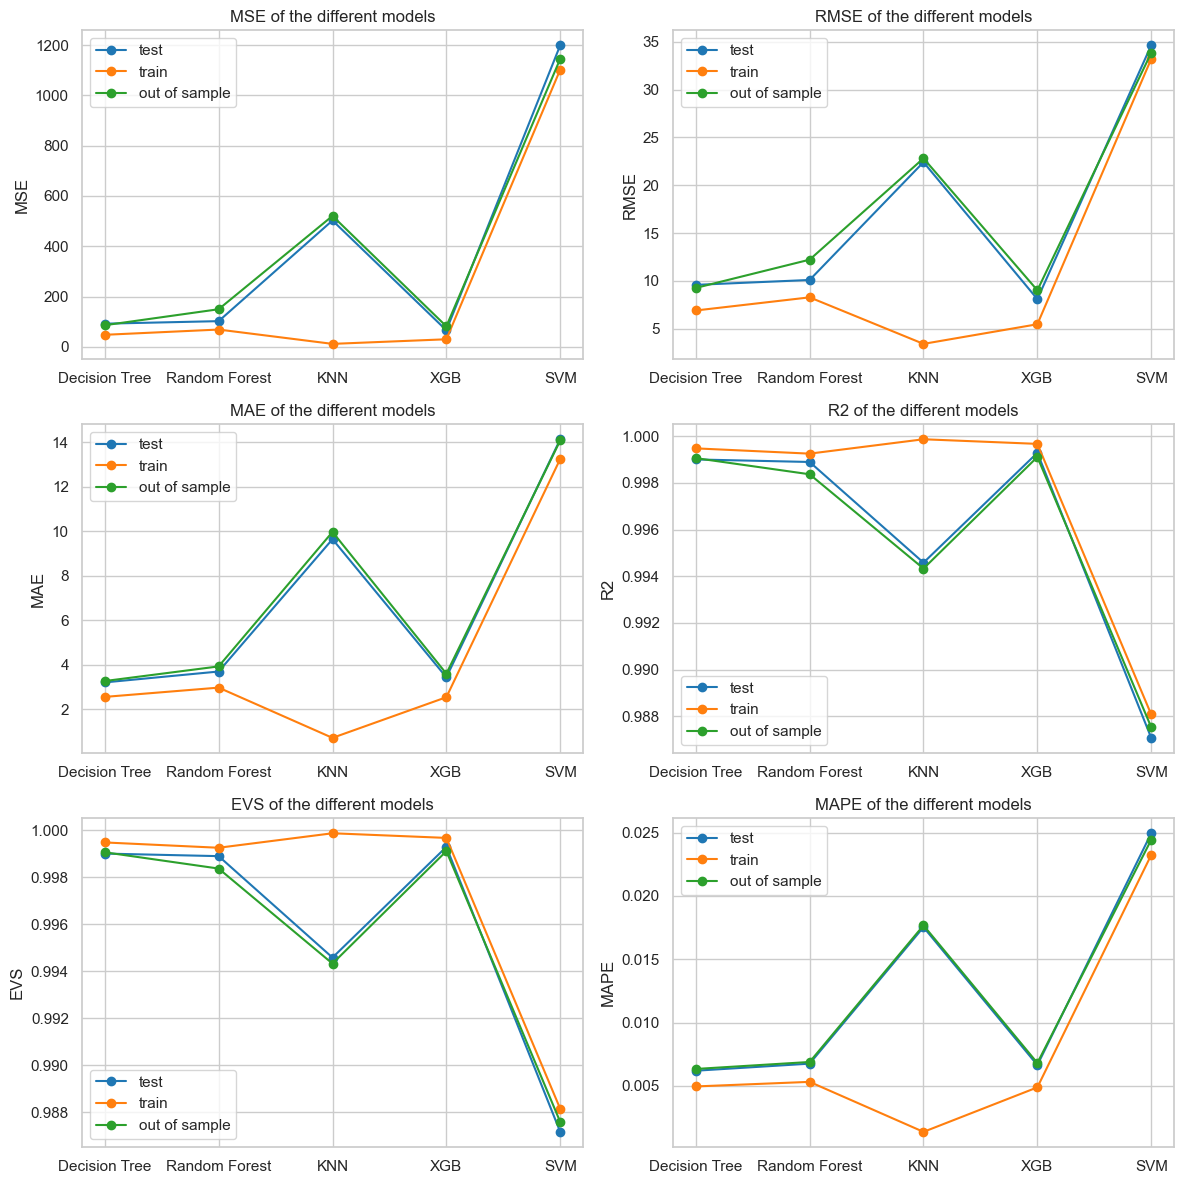

In [63]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']
# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = test_metrics.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(test_metrics.columns.str.replace(" Test",""), test_metrics.iloc[i], label="test", marker='o', color=colors[0])
    plt.plot(train_metrics.columns.str.replace(" Train",""), train_metrics.iloc[i], label="train", marker='o', color=colors[1])
    plt.plot(osample_metrics.columns.str.replace(" out of sample",""), osample_metrics.iloc[i], label="out of sample", marker='o', color=colors[2])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### 9.2 Predicted vs actual plots <a id="osample-predicted-actual"></a>

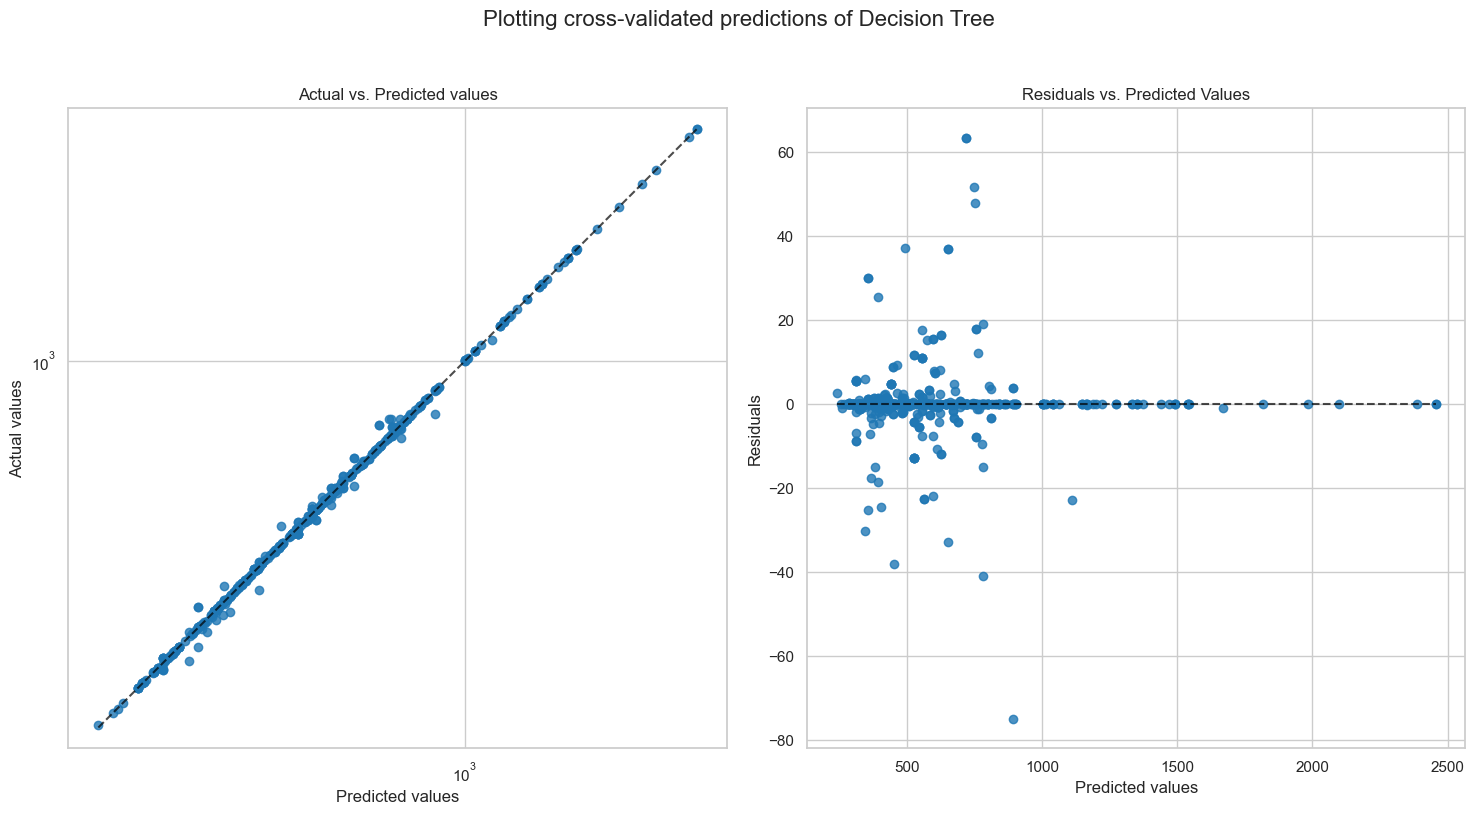

The mean residual of Decision Tree is: -0.14192113936983314


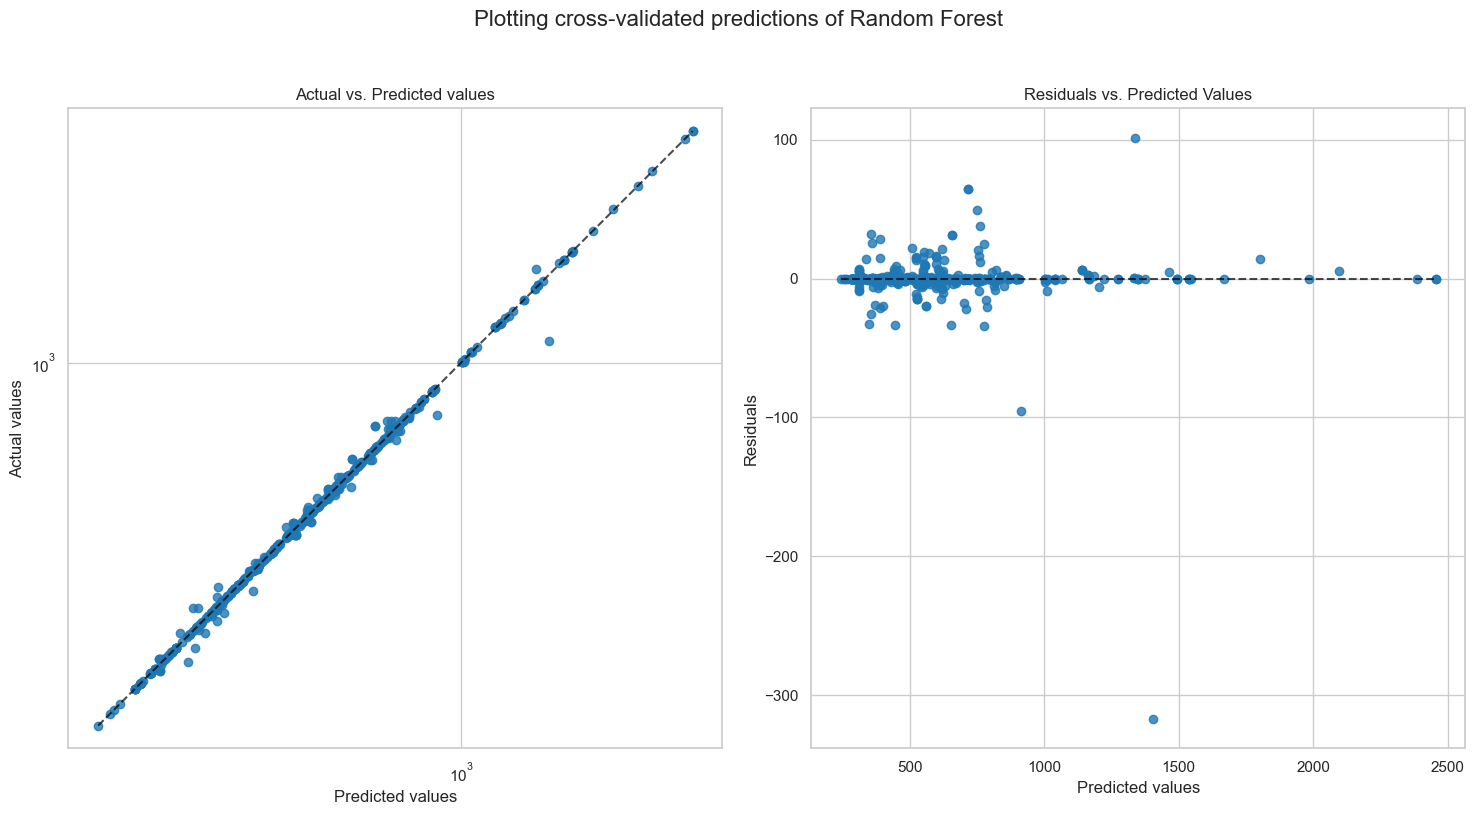

The mean residual of Random Forest is: -0.0004747767460958373


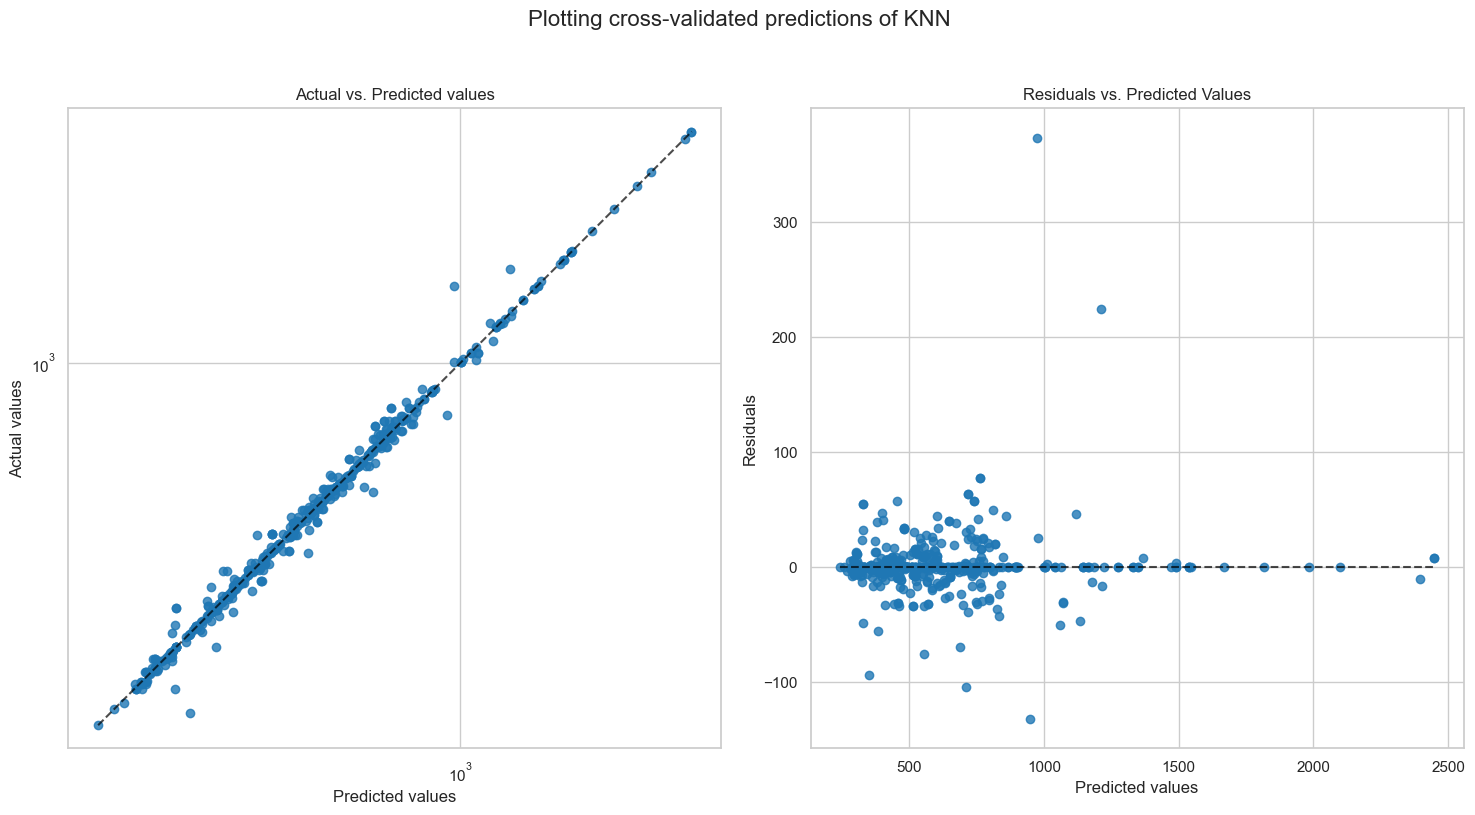

The mean residual of KNN is: 0.27529201301382844


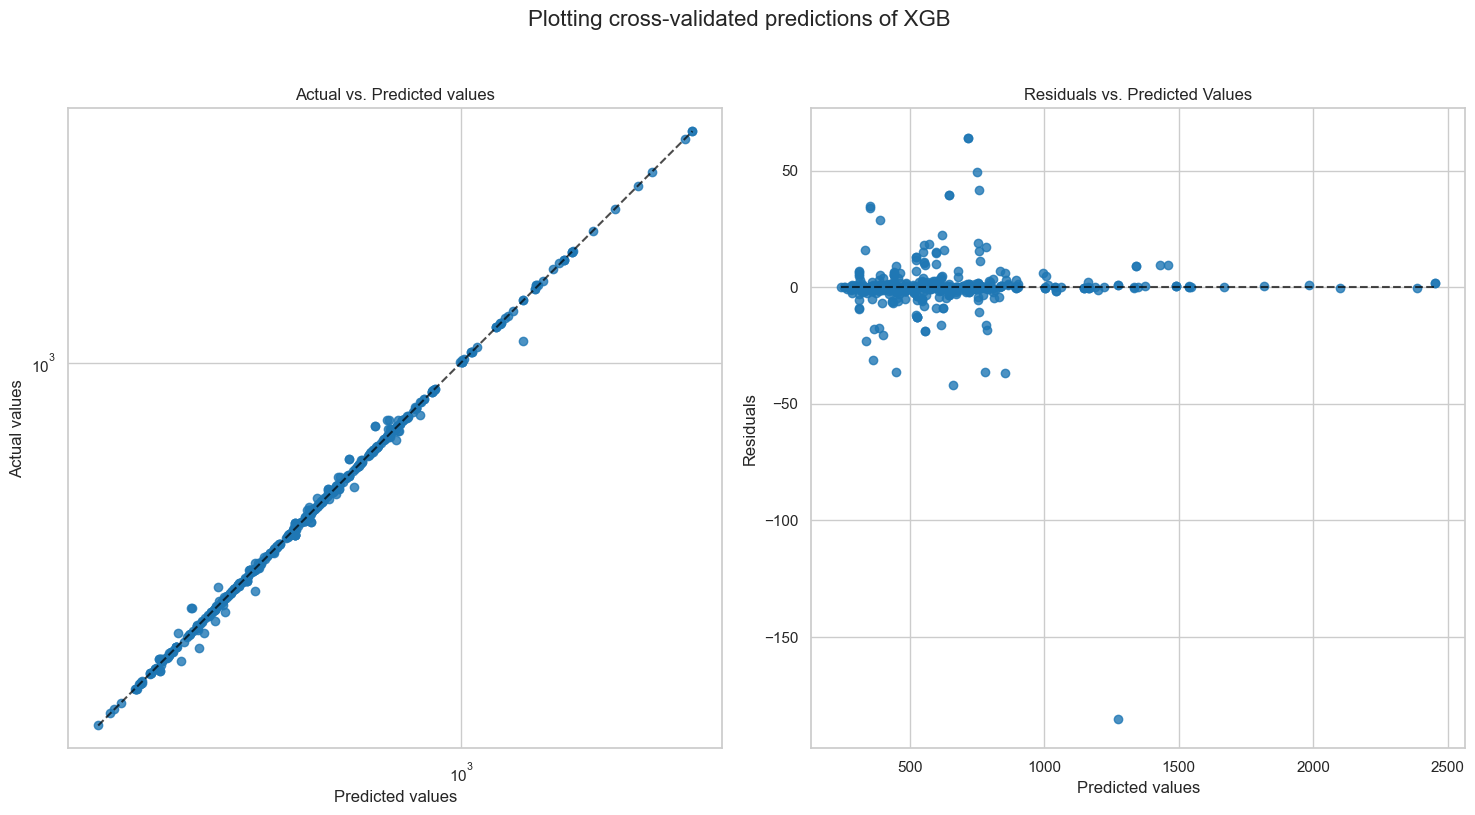

The mean residual of XGB is: -0.10674510261257672


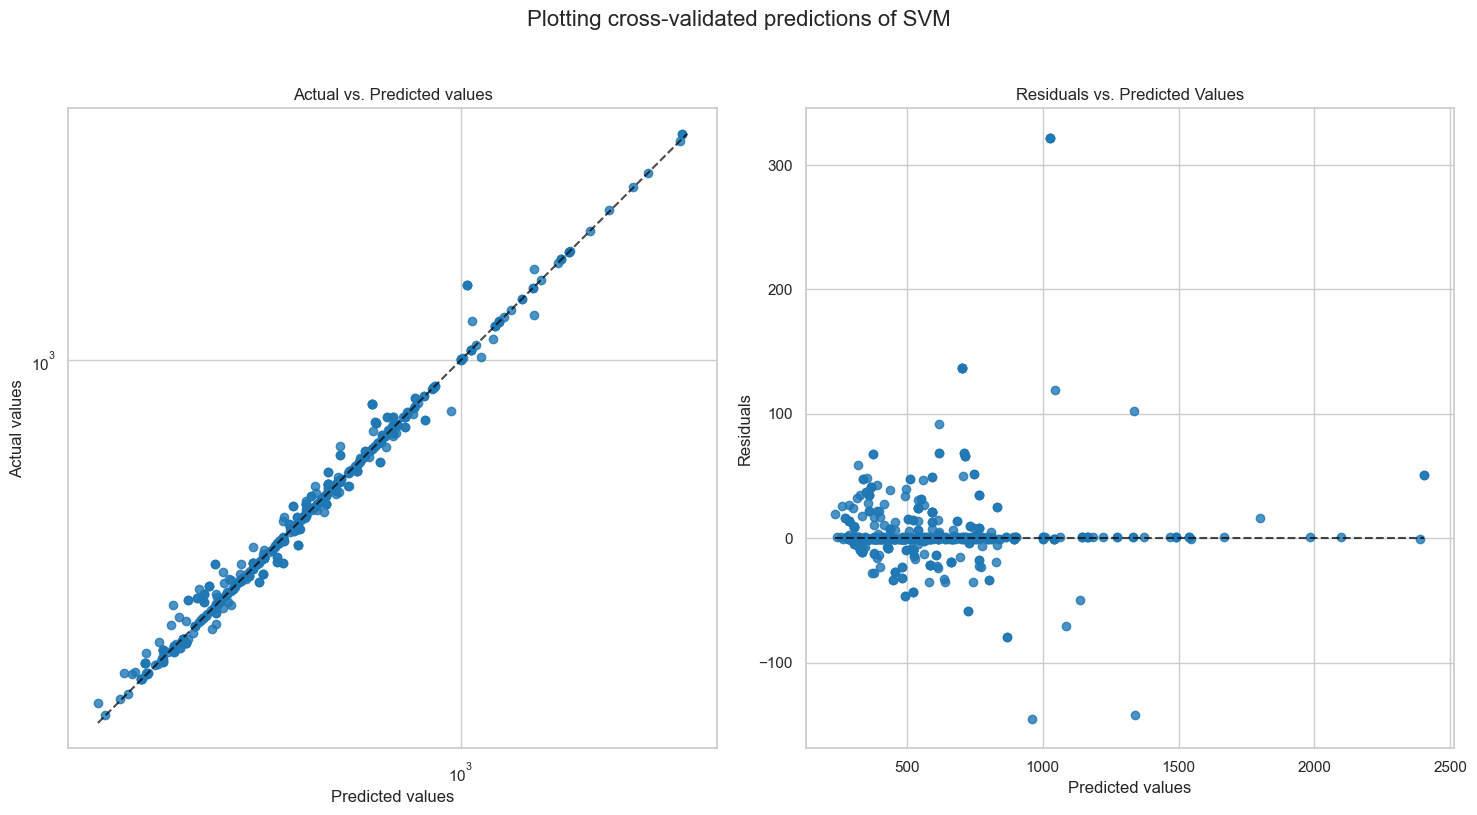

The mean residual of SVM is: 2.570945291058333


In [65]:
plotPvA(decisionTree_final, "Decision Tree", X_osample, y_osample)
plotPvA(randomForest_final, "Random Forest", X_osample, y_osample)
plotPvA(knn_final, "KNN", X_osample, y_osample)
plotPvA(xgb_final, "XGB", X_osample, y_osample)
plotPvA(svm_final, "SVM", X_osample, y_osample)

### 9.3 Histogram of residuals <a id="osample-histograms"></a>

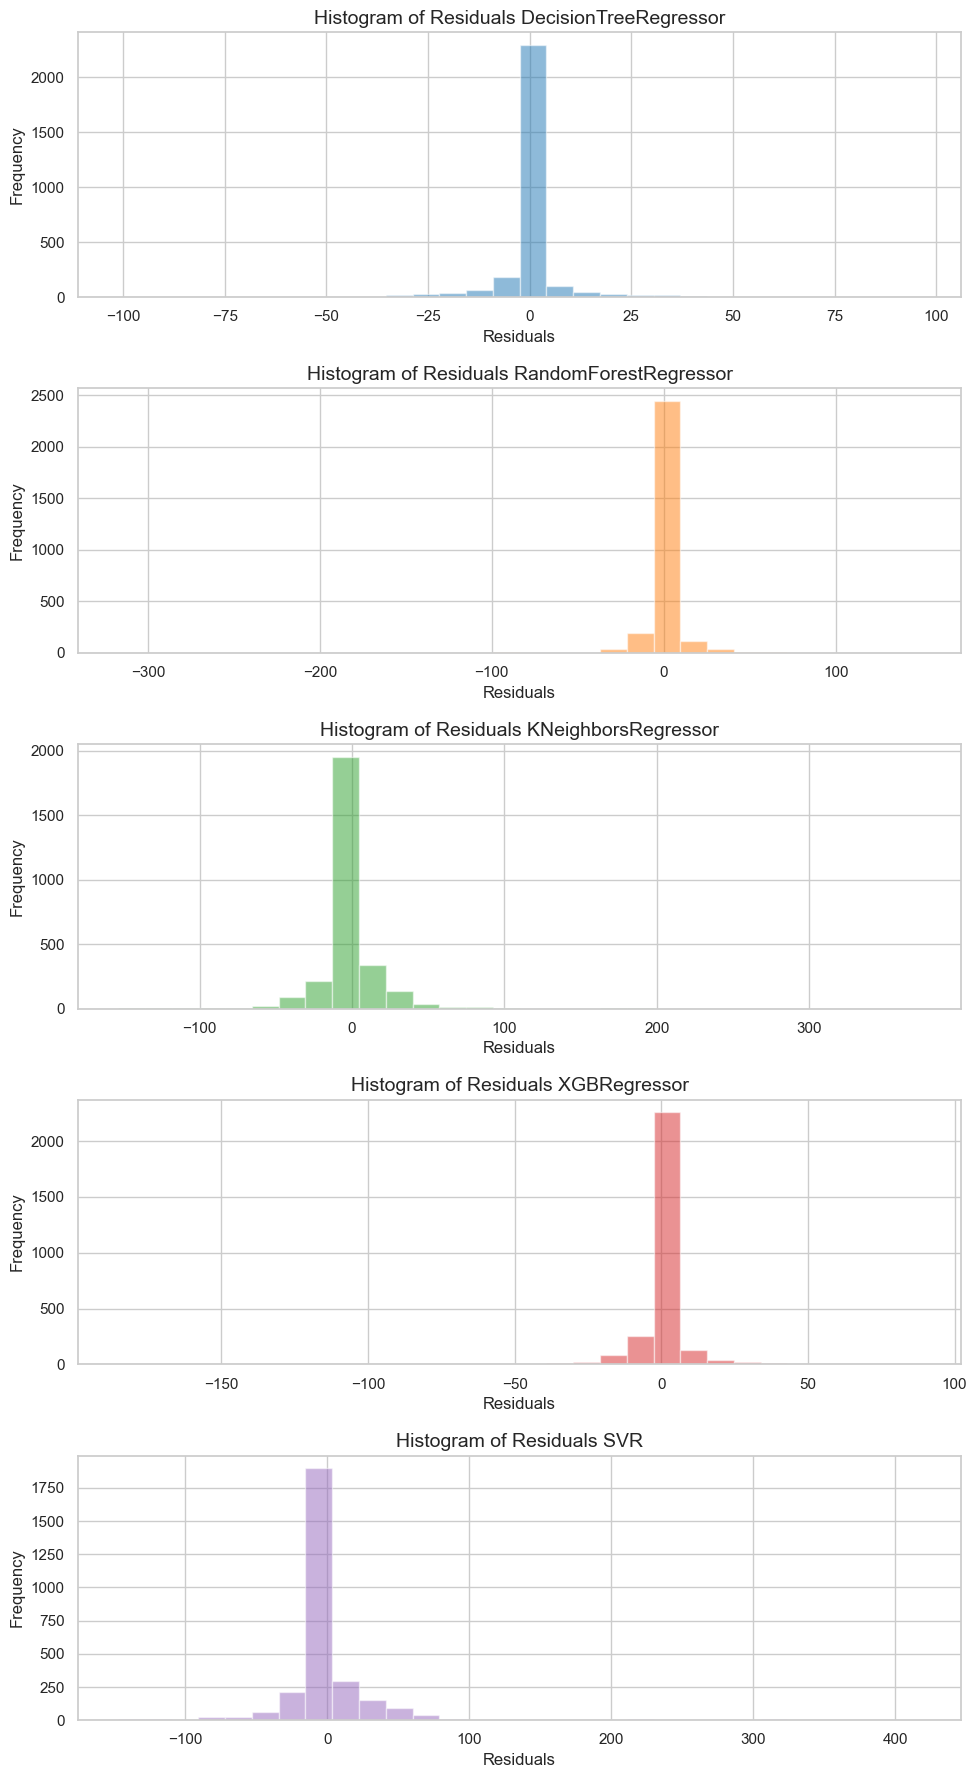

In [66]:
plotResiduals(models, X_osample, y_osample)

## 10 Feature Importance Analysis  <a id="feature-importance"></a>

#### Helper functions

In [67]:
def shapExplain(model):
    if model in [decisionTree_final, randomForest_final, xgb_final]:
        instructor = shap.TreeExplainer(decisionTree_final.named_steps["regressor"])
    elif model in [knn_final, svm_final]:
        instructor = shap.KernelExplainer(decisionTree_final.named_steps["regressor"])
    else:
        raise ValueError("Unsupported model type.")
    finding = model.named_steps["preprocessor"].transform(X_train)
    shap_values = instructor.shap_values(finding)
    shap.initjs()
    shap.summary_plot(shap_values, features=finding, feature_names=list(columns_pipeline), show = False)
    plt.show()
    return shap_values

In [68]:
def importance(values):
    X_train_processed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=columns_pipeline)
    shap_values_abs = np.abs(values)
    summary_df = pd.DataFrame([X_train_processed.columns, shap_values_abs.mean(axis=0)]).T
    summary_df.columns = ['Feature', 'mean_SHAP']
    summary_df['mean_SHAP'] = summary_df['mean_SHAP'].astype(float)
    mapping = pd.DataFrame(summary_df.groupby(summary_df['Feature'].str[0:5])['mean_SHAP'].mean()).reset_index() # extracting unique groups
    dic_to_replace = {'horse': "horsepower", 'brand': "brands",
                  'consu': 'consumption', 'model': 'model', 'milag': 'milage',
                  'regis': 'registration', 'durat': 'duration', 'fuel_': 'fuel_type', 'gear_':'gear_type', 'emiss': 'emission'}

    mapping = mapping.replace({"Feature": dic_to_replace})
    mapping = mapping.sort_values('mean_SHAP', ascending = False)
    mapping

    ## Adjust plot properly!
    height = mapping['mean_SHAP'].values
    bars = mapping['Feature'].to_list()
    y_pos = np.arange(len(bars))
    
    # Define custom colors for the bars
    bar_colors = ['cornflowerblue']

    # Create horizontal bars
    plt.barh(y_pos, height, color=bar_colors)

    # Set the y-axis labels
    plt.yticks(y_pos, bars)

    # Set the x-axis label and adjust its appearance
    plt.xlabel('Mean Absolute SHAP Value', fontsize=13, labelpad=15)
    plt.xticks(fontsize=11)

    # Customize the grid lines
    plt.grid(axis='both', linestyle='--', alpha=0.5)

    # Remove the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Set the alpha values for the remaining spines
    plt.gca().spines['bottom'].set_alpha(0.8)
    plt.gca().spines['left'].set_alpha(0.8)

    # Show the plot
    plt.show()


### 10.1 Decision tree feature importance <a id="importance-decisiontree"></a>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


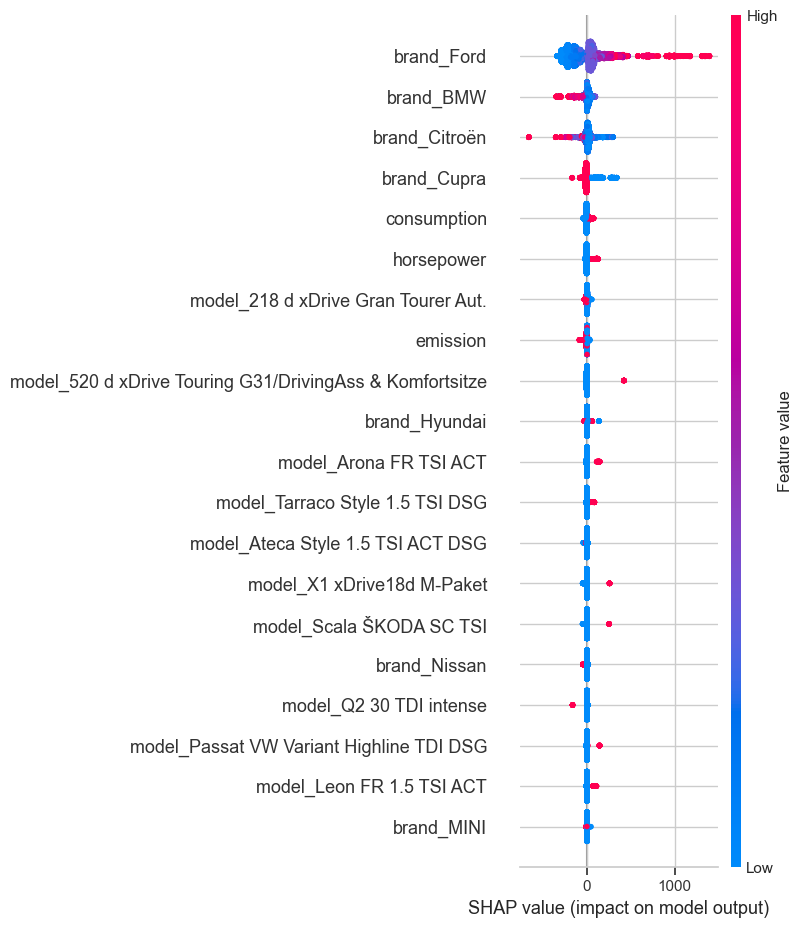

In [69]:
shap_values_decisionTree = shapExplain(decisionTree_final)

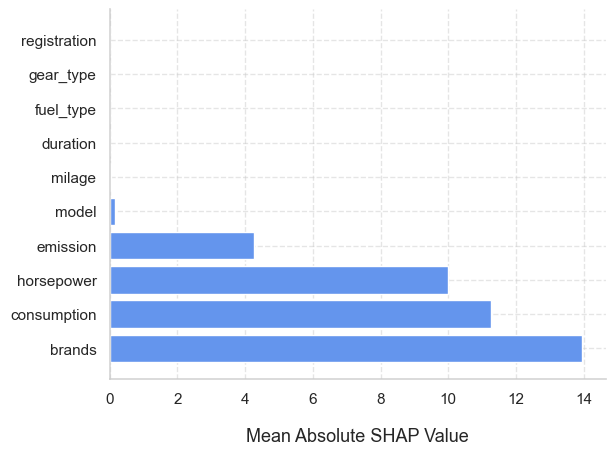

In [70]:
importance(shap_values_decisionTree)

### 10.2 Random forest feature importance <a id="importance-randomForest"></a>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


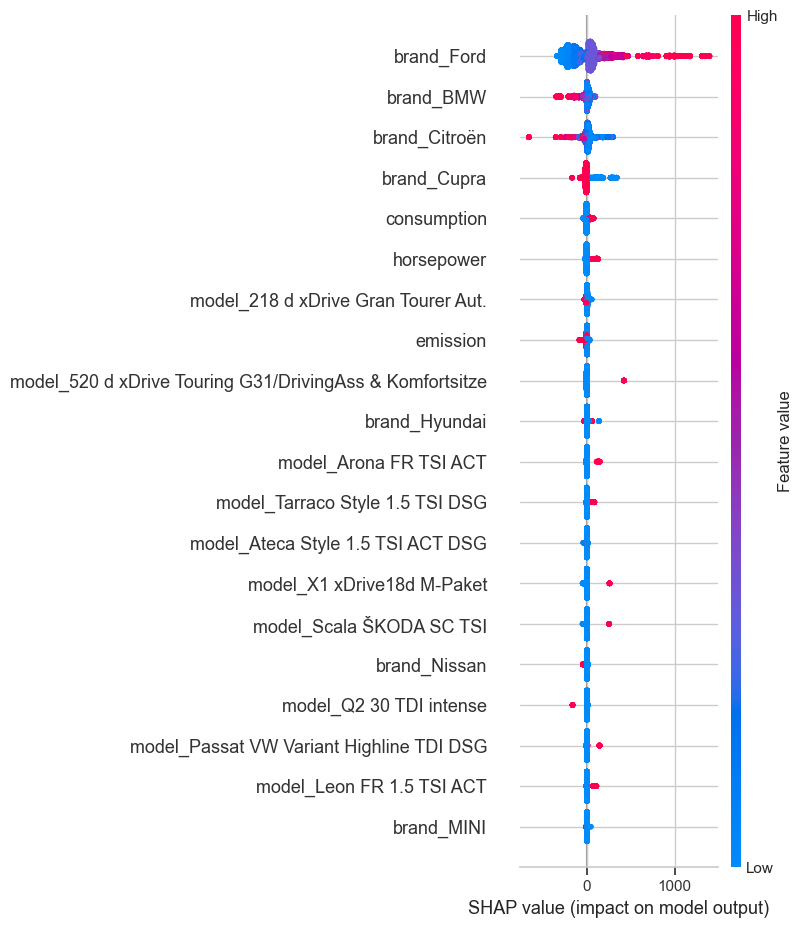

In [71]:
shap_values_randomForest = shapExplain(randomForest_final)

#### Average importance of each variable

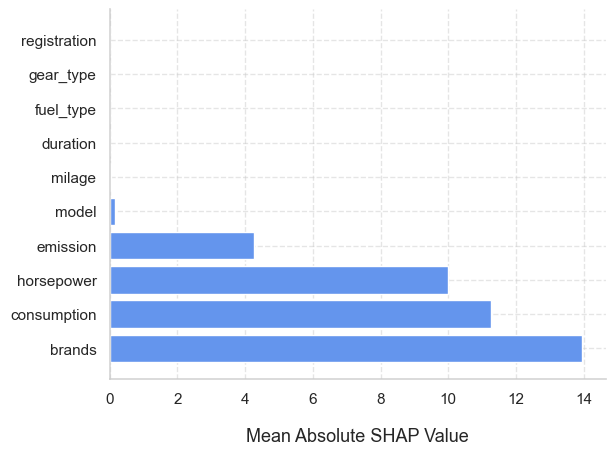

In [72]:
importance(shap_values_randomForest)

### 10.3 XGB feature importance <a id="importance-xgb"></a>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


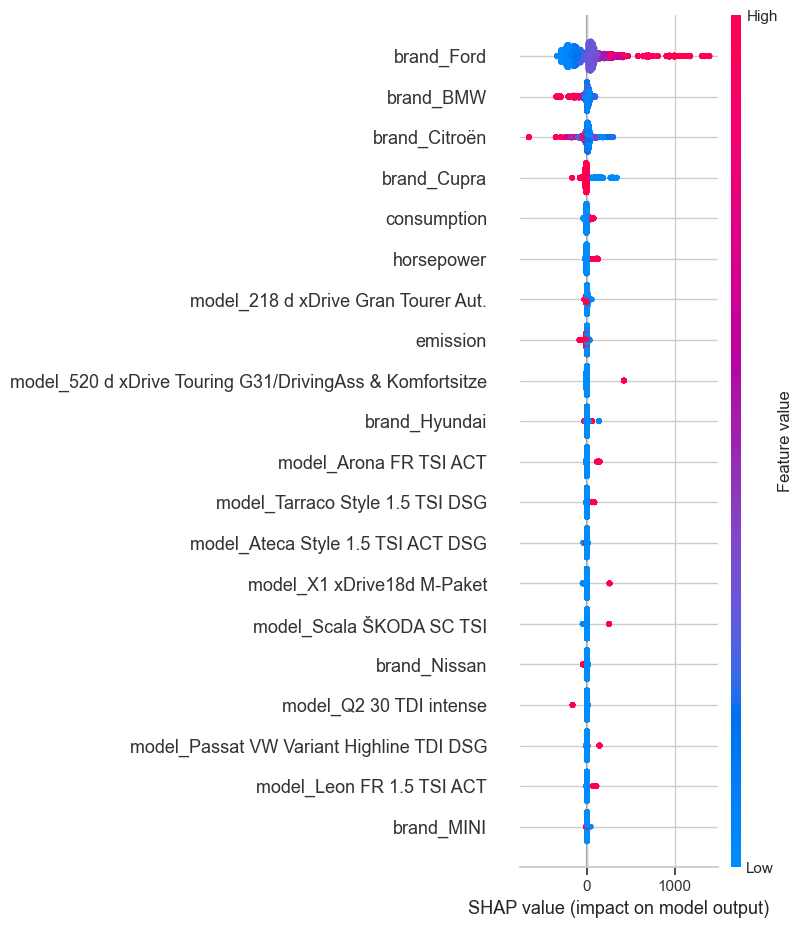

In [73]:
shap_values_xgb = shapExplain(xgb_final)

#### Average importance of each variable

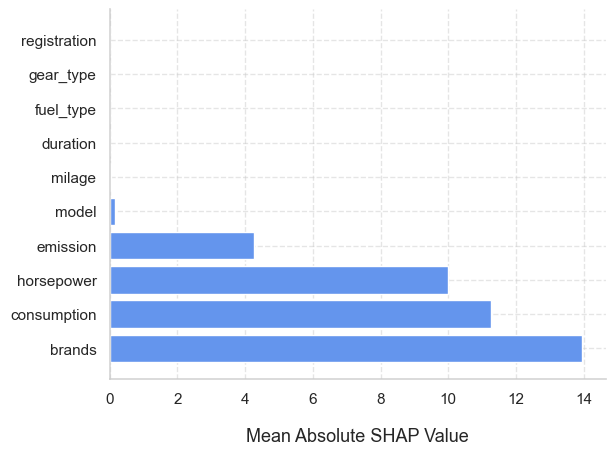

In [74]:
importance(shap_values_xgb)

## 11 Light models (reduced complexity)  <a id="light-models"></a>

In [ ]:
X_train_light = X_train.drop("model", axis=1)
X_test_light = X_test.drop("model", axis =1)
X_osample_light = X_osample.drop("model", axis = 1)
cat_FEATURES_light = cat_FEATURES.drop("model", axis=1)

In [ ]:
numeric_features = num_FEATURES.columns
categorical_features = cat_FEATURES_light.columns
preprocessor = ColumnTransformer(
    transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)    
    ])

In [ ]:
categorical_features

Index(['brand', 'gear', 'fuel'], dtype='object')

### 11.1 Best two performing full models  <a id="light-best"></a>

#### 11.1.2 Random Forest  <a id="light-tree"></a>

In [ ]:
# Define the parameter distribution
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    param_dist = {
        #'regressor__max_depth': randint(1, 10), # increasing depth always increases score -> overfitting
        'regressor__min_samples_split': [10, 20, 30, 40 ,50, 60, 70],
        'regressor__min_samples_leaf': [2, 4, 8, 10, 15, 20 ,30],
        'regressor__ccp_alpha': uniform(0, 0.1) # search for best ccp_alpha
    }

    # Create a new pipeline with the decision tree regression model
    decisionTree_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", DecisionTreeRegressor())
    ])

    # Perform randomized search with cross-validation
    decisionTree_randomized_search = RandomizedSearchCV(
        decisionTree_pipeline, 
        param_dist, 
        n_iter=3*iterations, 
        cv=2*crossvals, 
        scoring=scoring, 
        refit='MSE', 
        random_state=SEED, 
        n_jobs = cores,
        verbose = 3)
    decisionTree_randomized_search.fit(X_train_light, y_train)

    # evaluation metrics
    train_metrics_light = evaluate(decisionTree_randomized_search, X_train_light, y_train)
    test_metrics_light = evaluate(decisionTree_randomized_search, X_test_light, y_test)

    # create a dataframe from metrics
    decisionTree_rand_metrics = pd.DataFrame({'Train Set': train_metrics_light, 'Test Set': test_metrics_light})

    print("\nEvaluation Metrics:")
    print(decisionTree_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = decisionTree_randomized_search.best_params_

    decisionTree_params = pd.DataFrame({"Parameters": best_params})
    print(decisionTree_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")



CPU usage: 0.6%
Memory usage: svmem(total=34276040704, available=21338042368, percent=37.7, used=12937998336, free=21338042368)%
Fitting 10 folds for each of 90 candidates, totalling 900 fits

Evaluation Metrics:
       Train Set    Test Set
MSE   209.742431  406.373134
RMSE   14.482487   20.158699
MAE     4.266952    6.065162
R2      0.997731    0.995619
EVS     0.997731    0.995619
MAPE    0.007943    0.011467
                              Parameters
regressor__ccp_alpha            0.018405
regressor__min_samples_leaf     2.000000
regressor__min_samples_split   10.000000
Computation time: 10.009563684463501


In [ ]:
if compute:
    finalTree_light = DecisionTreeRegressor(
        ccp_alpha = best_params['regressor__ccp_alpha'],
        min_samples_leaf = best_params['regressor__min_samples_leaf'],
        min_samples_split = best_params['regressor__min_samples_split']
    )

    decisionTree_light_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalTree_light)
    ])
    decisionTree_light_final.fit(X_train_light, y_train)
else:
    decisionTree_light_final = load(f'{modelfolder}/decisionTree_light.joblib')

train_metrics_light = evaluate(decisionTree_light_final, X_train_light, y_train)
test_metrics_light = evaluate(decisionTree_light_final, X_test_light, y_test)

# create a dataframe from metrics
decisionTree_light_metrics = pd.DataFrame({'Decision Tree Train':train_metrics_light, 'Decision Tree Test': test_metrics_light})

print("\nEvaluation Metrics:")
print(decisionTree_light_metrics)


Evaluation Metrics:
      Decision Tree Train  Decision Tree Test
MSE            209.742431          413.383357
RMSE            14.482487           20.331831
MAE              4.266952            6.098616
R2               0.997731            0.995543
EVS              0.997731            0.995543
MAPE             0.007943            0.011526


#### 11.1.2 Random Forest  <a id="light-forest"></a>

In [ ]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    param_dist = {
        'regressor__n_estimators': [100, 300, 500, 600, 700, 800, 900, 1000],
        'regressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80],
        'regressor__min_samples_split': [10, 12, 15, 20, 30, 40, 50, 60],
        'regressor__min_samples_leaf': [6, 8, 10, 15, 20, 30, 40, 50]
    }

    rf_randomized_search = RandomizedSearchCV(
        rf_pipeline, 
        param_distributions=param_dist, 
        n_iter = 3*iterations, 
        cv=2*crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        n_jobs = cores,
        verbose = 3)

    rf_randomized_search.fit(X_train_light, y_train)

    # evaluation metrics
    train_metrics_light = evaluate(rf_randomized_search, X_train_light, y_train)
    test_metrics_light = evaluate(rf_randomized_search, X_test_light, y_test)

    # create a dataframe from metrics
    randomForest_rand_metrics = pd.DataFrame({'Train Set': train_metrics_light, 'Test Set': test_metrics_light})

    print("\nEvaluation Metrics:")
    print(randomForest_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = rf_randomized_search.best_params_

    randomForest_params = pd.DataFrame({"Parameters": best_params})
    print(randomForest_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")



CPU usage: 2.3%
Memory usage: svmem(total=34276040704, available=21407842304, percent=37.5, used=12868198400, free=21407842304)%
Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU usage: 66.8%
Memory usage: svmem(total=34276040704, available=19473563648, percent=43.2, used=14802477056, free=19473563648)%
CPU usage: 78.6%
Memory usage: svmem(total=34276040704, available=19033309184, percent=44.5, used=15242731520, free=19033309184)%
CPU usage: 78.6%
Memory usage: svmem(total=34276040704, available=19707826176, percent=42.5, used=14568214528, free=19707826176)%
CPU usage: 78.7%
Memory usage: svmem(total=34276040704, available=19476279296, percent=43.2, used=14799761408, free=19476279296)%
CPU usage: 79.1%
Memory usage: svmem(total=34276040704, available=19850948608, percent=42.1, used=14425092096, free=19850948608)%
CPU usage: 86.1%
Memory usage: svmem(total=34276040704, available=19570376704, percent=42.9, used=14705664000, free=19570376704)%
CPU usage: 90.9%
Memory usag

In [ ]:
if compute:
    finalForest_light = RandomForestRegressor(
        n_estimators = best_params['regressor__n_estimators'],
        min_samples_split = best_params['regressor__min_samples_split'],
        min_samples_leaf = best_params['regressor__min_samples_leaf'],
        max_depth = best_params['regressor__max_depth']
    )

    randomForest_light_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalForest_light)
    ])
    randomForest_light_final.fit(X_train_light, y_train)

else:
    randomForest_light_final = load(f'{modelfolder}/randomForest_light.joblib')

train_metrics_light = evaluate(randomForest_light_final, X_train_light, y_train)
test_metrics_light = evaluate(randomForest_light_final, X_test_light, y_test)

# create a dataframe from metrics
randomForest_light_metrics = pd.DataFrame({'Random Forest Train':train_metrics_light, 'Random Forest Test': test_metrics_light})

print("\nEvaluation Metrics:")
print(randomForest_light_metrics)


Evaluation Metrics:
      Random Forest Train  Random Forest Test
MSE            385.868909          451.555470
RMSE            19.643546           21.249835
MAE              7.373744            8.347957
R2               0.995825            0.995132
EVS              0.995825            0.995133
MAPE             0.012751            0.014797


#### 11.1.3 XGB <a id="light-xgb"></a>

In [ ]:
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    
    # Define the parameter distribution
    param_dist = {
        'regressor__max_depth': [15, 20, 25, 30, 35, 40, 45, 50 , 55, 60, 65, 70],
        'regressor__learning_rate': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.10, 0.2, 0.3, 0.5],
        'regressor__n_estimators': [125, 150, 160, 175, 185, 200, 225, 250, 275, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500],
        'regressor__gamma': [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55],
        'regressor__subsample': [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8,0.9],
        'regressor__colsample_bytree': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
        'regressor__min_child_weight':randint(1,20),
        'regressor__reg_lambda': [0, 0.001, 0.004, 0.006, 0.01, 0.05, 0.1, 1, 2, 3, 4, 5, 6, 7, 10],
        'regressor__reg_alpha' :[0, 1, 10, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100],
        'regressor__tree_method':["gpu_hist"],
    }

    # Create a new pipeline with the XGBoost regressor model
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor())
    ])

    # Perform randomized search with cross-validation
    xgb_randomized_search = RandomizedSearchCV(
        xgb_pipeline,
        param_dist,
        n_iter=3*iterations,
        cv=2*crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=cores,
        verbose = 3)
        
    xgb_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics_light = evaluate(xgb_randomized_search, X_train, y_train)
    test_metrics_light = evaluate(xgb_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    xgb_rand_metrics = pd.DataFrame({'Train Set': train_metrics_light, 'Test Set': test_metrics_light})

    print("\nEvaluation Metrics:")
    print(xgb_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = xgb_randomized_search.best_params_
    xgb_params = pd.DataFrame({"Parameters": best_params})
    print(xgb_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")

CPU usage: 2.5%
Memory usage: svmem(total=34276040704, available=20512382976, percent=40.2, used=13763657728, free=20512382976)%
Fitting 10 folds for each of 90 candidates, totalling 900 fits
CPU usage: 82.1%
Memory usage: svmem(total=34276040704, available=17220538368, percent=49.8, used=17055502336, free=17220538368)%
CPU usage: 86.4%
Memory usage: svmem(total=34276040704, available=17124716544, percent=50.0, used=17151324160, free=17124716544)%
CPU usage: 85.8%
Memory usage: svmem(total=34276040704, available=17124773888, percent=50.0, used=17151266816, free=17124773888)%
CPU usage: 84.9%
Memory usage: svmem(total=34276040704, available=17113300992, percent=50.1, used=17162739712, free=17113300992)%
CPU usage: 89.7%
Memory usage: svmem(total=34276040704, available=17049661440, percent=50.3, used=17226379264, free=17049661440)%
CPU usage: 86.7%
Memory usage: svmem(total=34276040704, available=17098117120, percent=50.1, used=17177923584, free=17098117120)%
CPU usage: 85.6%
Memory usag

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


CPU usage: 81.9%
Memory usage: svmem(total=34276040704, available=18218610688, percent=46.8, used=16057430016, free=18218610688)%
CPU usage: 77.8%
Memory usage: svmem(total=34276040704, available=17888964608, percent=47.8, used=16387076096, free=17888964608)%
CPU usage: 77.4%
Memory usage: svmem(total=34276040704, available=17950658560, percent=47.6, used=16325382144, free=17950658560)%
CPU usage: 75.5%
Memory usage: svmem(total=34276040704, available=17970810880, percent=47.6, used=16305229824, free=17970810880)%
CPU usage: 78.5%
Memory usage: svmem(total=34276040704, available=17952088064, percent=47.6, used=16323952640, free=17952088064)%
CPU usage: 78.3%
Memory usage: svmem(total=34276040704, available=17948573696, percent=47.6, used=16327467008, free=17948573696)%
CPU usage: 86.0%
Memory usage: svmem(total=34276040704, available=18045554688, percent=47.4, used=16230486016, free=18045554688)%
CPU usage: 82.1%
Memory usage: svmem(total=34276040704, available=17924358144, percent=47.

In [ ]:
if compute:
    finalXGB_light = XGBRegressor(
        colsample_bytree = best_params['regressor__colsample_bytree'], 
        gamma = best_params['regressor__gamma'],
        learning_rate = best_params['regressor__learning_rate'], 
        max_depth = best_params['regressor__max_depth'],
        subsample = best_params['regressor__subsample'],
        n_estimators = best_params['regressor__n_estimators'],
        min_child_weight = best_params['regressor__min_child_weight'],
        reg_alpha = best_params['regressor__reg_alpha'],
        reg_lambda = best_params['regressor__reg_lambda'],
        tree_method = best_params['regressor__tree_method'],
    )

    xgb_light_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalXGB_light)
    ])
    xgb_light_final.fit(X_train, y_train)

else:
    xgb_light_final = load(f'{modelfolder}/XGBoost_light.joblib')

train_metrics_light = evaluate(xgb_light_final, X_train, y_train)
test_metrics_light = evaluate(xgb_light_final, X_test, y_test)

# Create a DataFrame from metrics
xgb_light_metrics = pd.DataFrame({'XGB Train': train_metrics_light, 'XGB Test': test_metrics_light})

print("\nEvaluation Metrics:")
print(xgb_light_metrics)


Evaluation Metrics:
       XGB Train    XGB Test
MSE   178.409506  365.090424
RMSE   13.357002   19.107340
MAE     5.696037    8.364257
R2      0.998070    0.996064
EVS     0.998070    0.996065
MAPE    0.010674    0.015629


### 11.2 Performance full vs light models  <a id="light-comparison"></a>

In [ ]:
decisionTree_light_osample_metrics = getMetrics(decisionTree_light_final, "Decision Tree out of sample", X_osample, y_osample)
randomForest_light_osample_metrics = getMetrics(randomForest_light_final, "Random Forest out of sample", X_osample, y_osample)
xgb_light_osample_metrics = getMetrics(xgb_light_final,"XGB out of sample", X_osample, y_osample)

In [ ]:
metrics = [decisionTree_light_metrics ,randomForest_light_metrics, xgb_light_metrics]

# Create empty DataFrames for train metrics and test metrics
train_metrics_light = pd.DataFrame()
test_metrics_light = pd.DataFrame()

# Loop through the metrics list and assign train and test metrics to respective DataFrames
for metric in metrics:
    for col in metric.columns:
        if "Train" in col:
            train_metrics_light = pd.concat([train_metrics_light, metric[[col]]], axis=1)
        elif "Test" in col:
            test_metrics_light = pd.concat([test_metrics_light, metric[[col]]], axis=1)

In [ ]:
osample_metrics_light = pd.concat([decisionTree_light_osample_metrics,
                            randomForest_light_osample_metrics,
                            xgb_light_osample_metrics],
                            axis=1)

In [ ]:
osample_metrics_light

Decision Tree out of sample  Random Forest out of sample   
MSE                    412.294540                   587.562125  \
RMSE                    20.305037                    24.239681   
MAE                      6.260306                     8.837030   
R2                       0.995510                     0.993601   
EVS                      0.995512                     0.993601   
MAPE                     0.011746                     0.015039   

      XGB out of sample  
MSE          428.523895  
RMSE          20.700819  
MAE            8.888611  
R2             0.995333  
EVS            0.995334  
MAPE           0.016270

In [ ]:
osample_metrics[osample_metrics_light.columns]

Decision Tree out of sample  Random Forest out of sample   
MSE                     86.005198                   149.547716  \
RMSE                     9.273899                    12.228970   
MAE                      3.260411                     3.918312   
R2                       0.999063                     0.998371   
EVS                      0.999064                     0.998371   
MAPE                     0.006344                     0.006896   

      XGB out of sample  
MSE           81.498908  
RMSE           9.027675  
MAE            3.590986  
R2             0.999112  
EVS            0.999113  
MAPE           0.006816

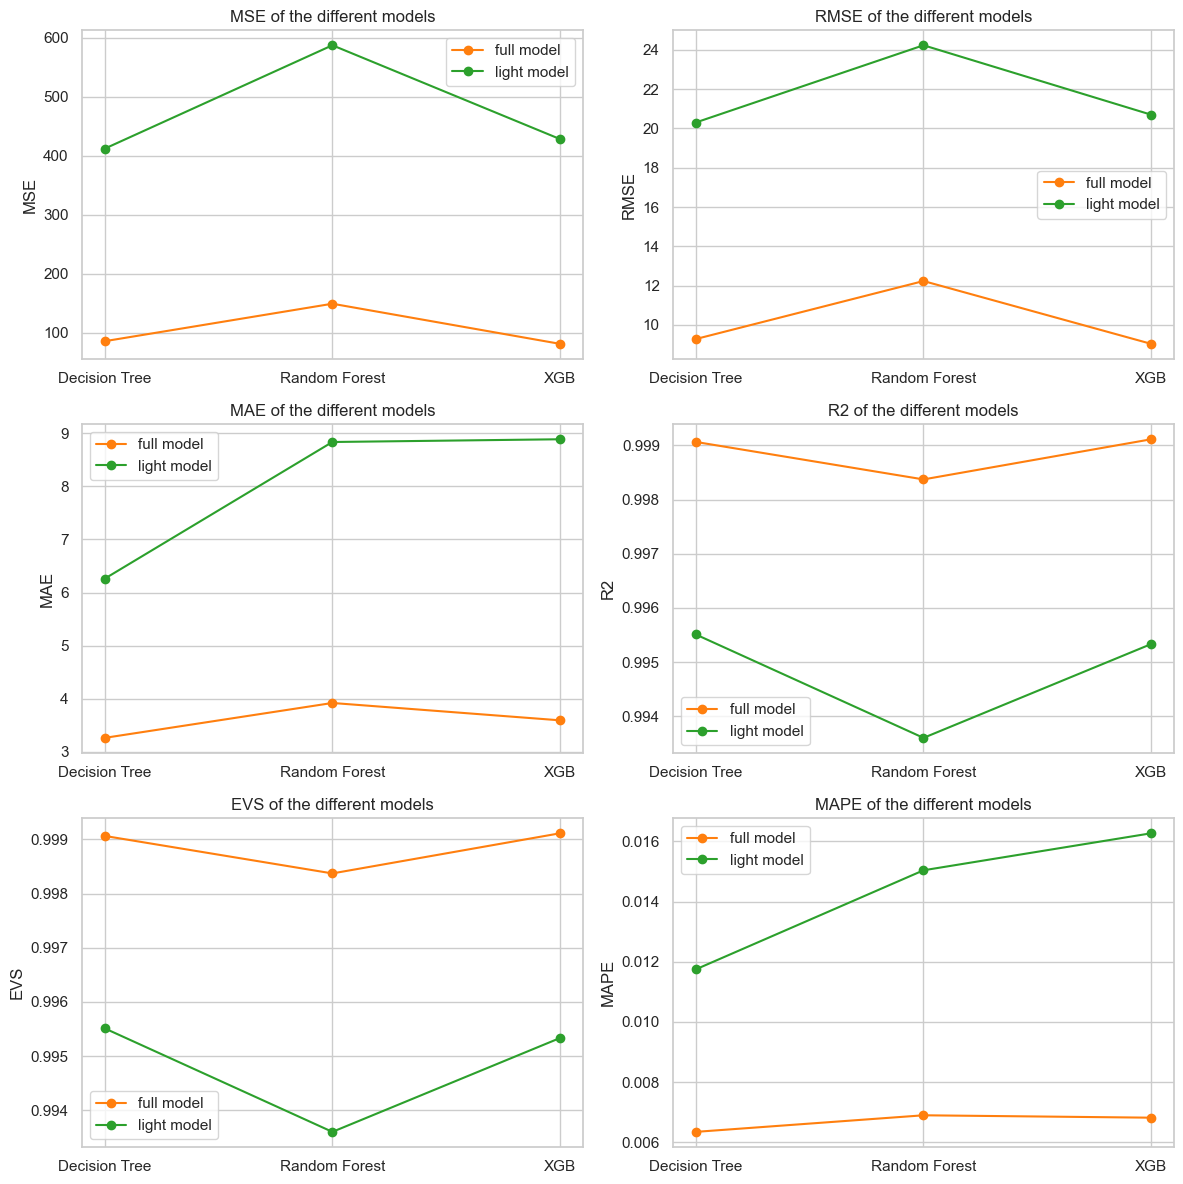

In [ ]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']

# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = osample_metrics_light.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(osample_metrics[osample_metrics_light.columns].columns.str.replace(" out of sample",""), osample_metrics[osample_metrics_light.columns].iloc[i], label="full model", marker='o', color=colors[1])
    plt.plot(osample_metrics_light.columns.str.replace(" out of sample",""), osample_metrics_light.iloc[i], label="light model", marker='o', color=colors[2])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### 11.2.1 Performance full vs light models  <a id="light-comparison-PvA"></a>

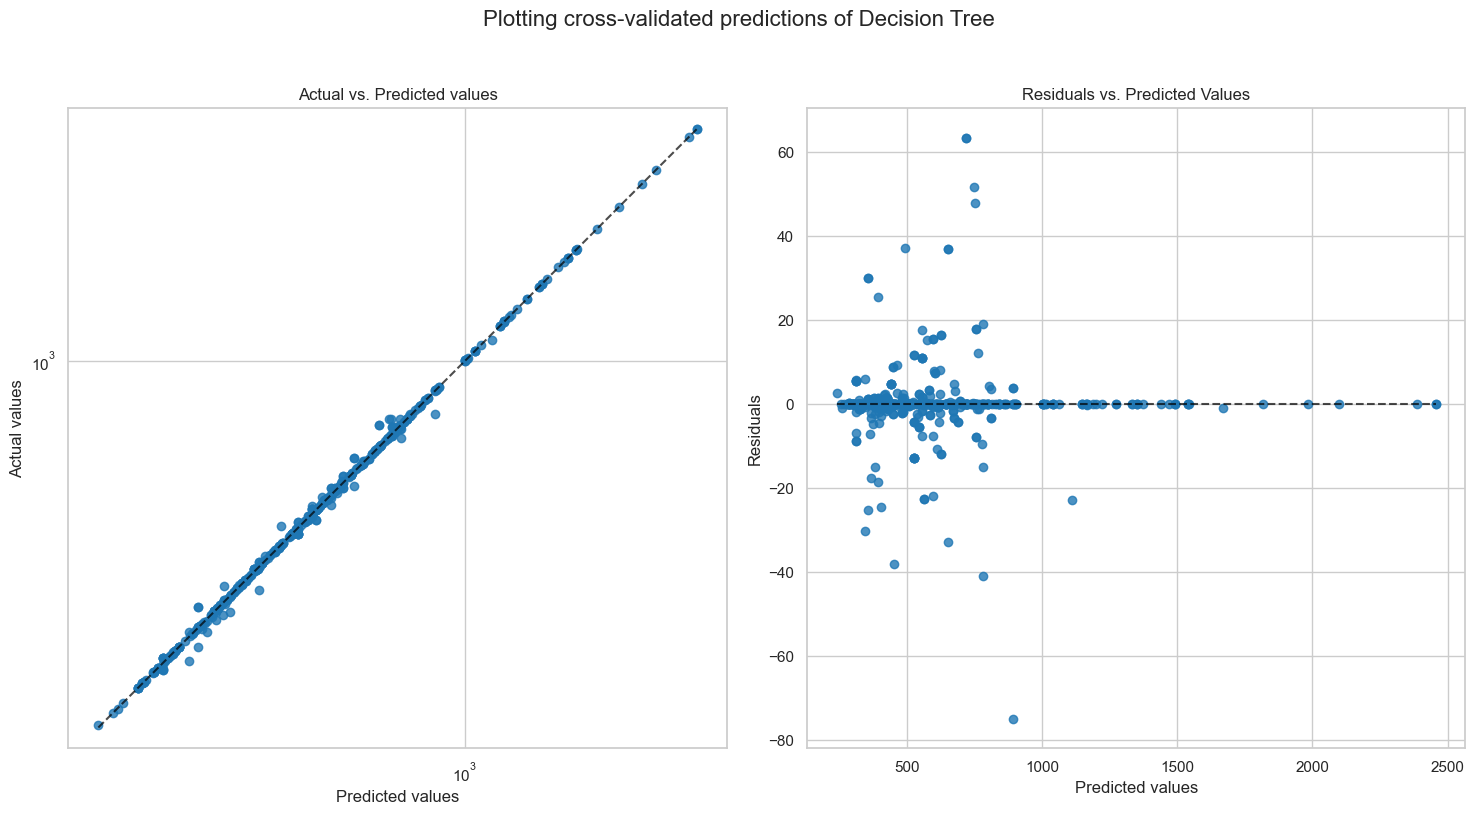

The mean residual of Decision Tree is: -0.14192113936983314


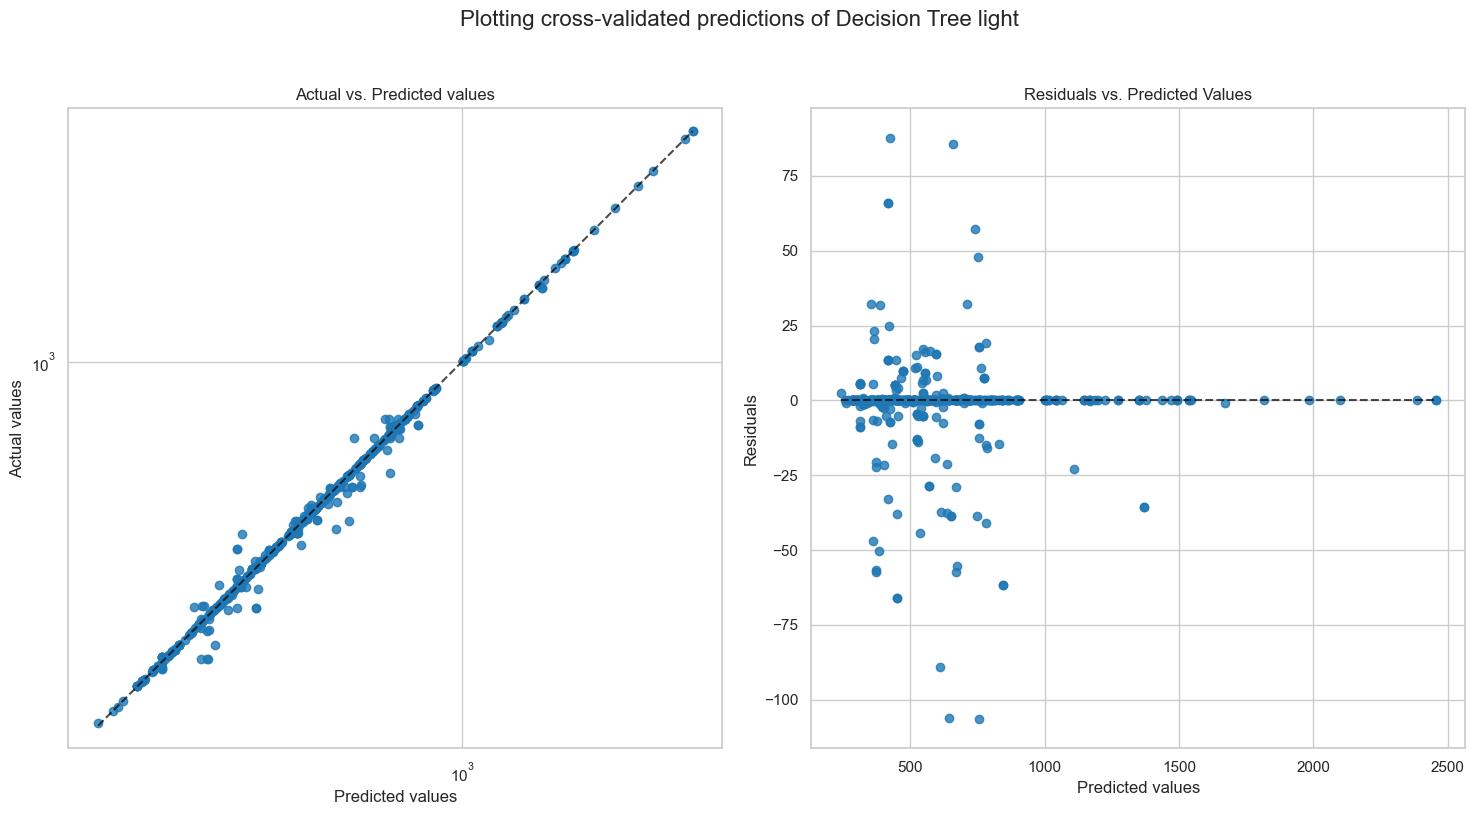

The mean residual of Decision Tree light is: -0.46648864660616046


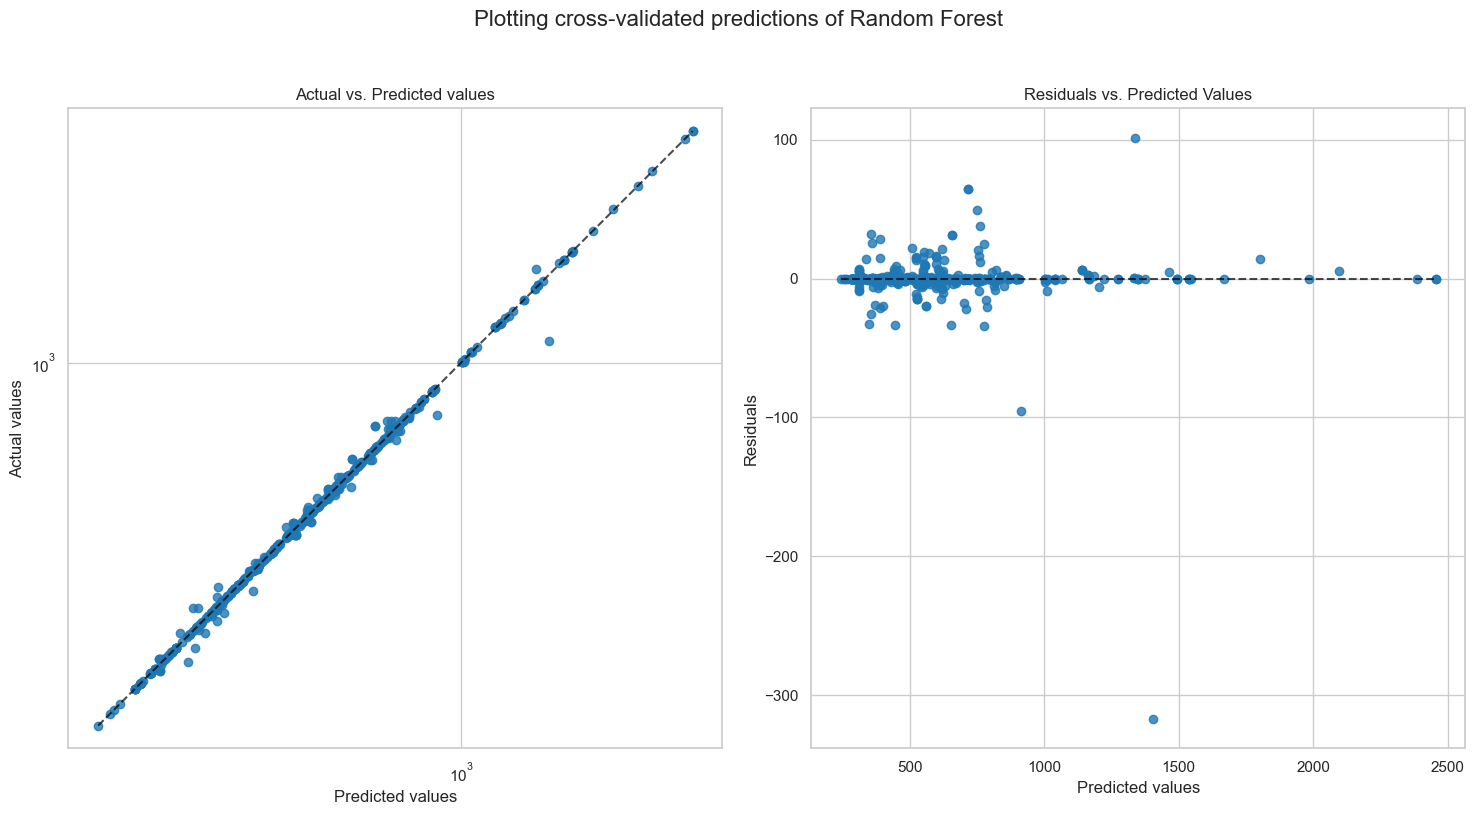

The mean residual of Random Forest is: -0.0004747767460958373


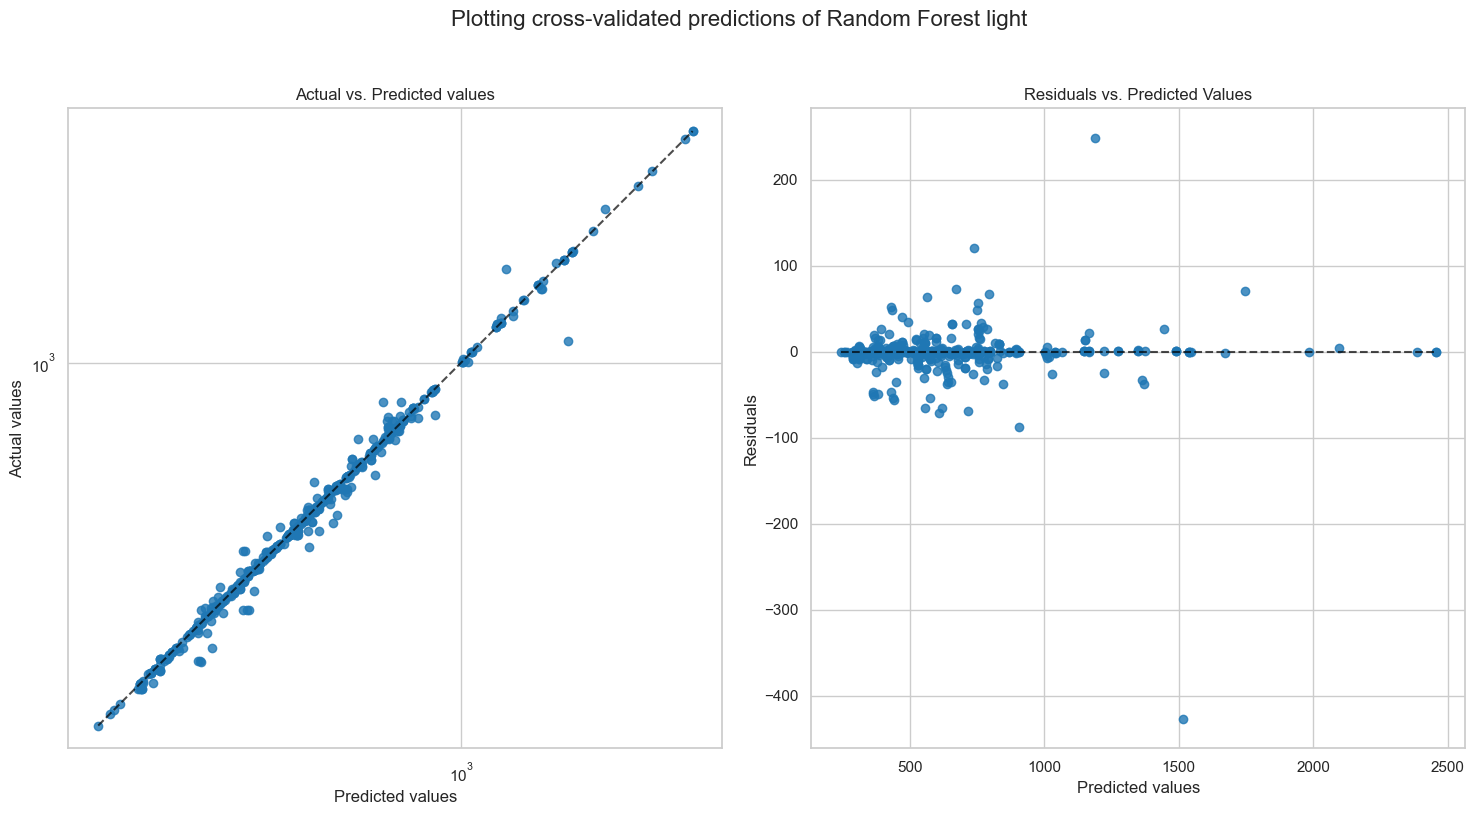

The mean residual of Random Forest light is: 0.10922425080982177


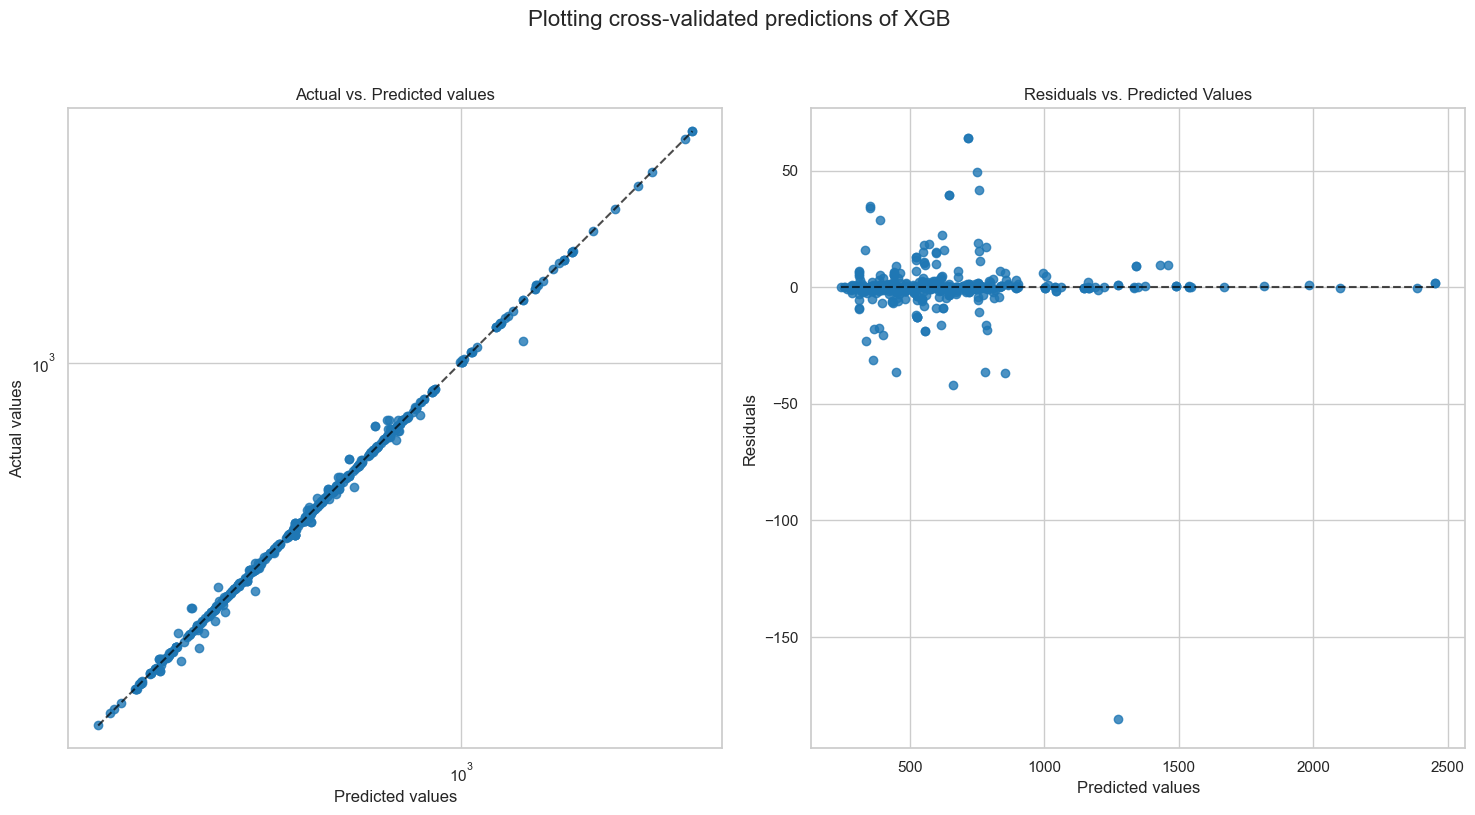

The mean residual of XGB is: -0.10674510261257672


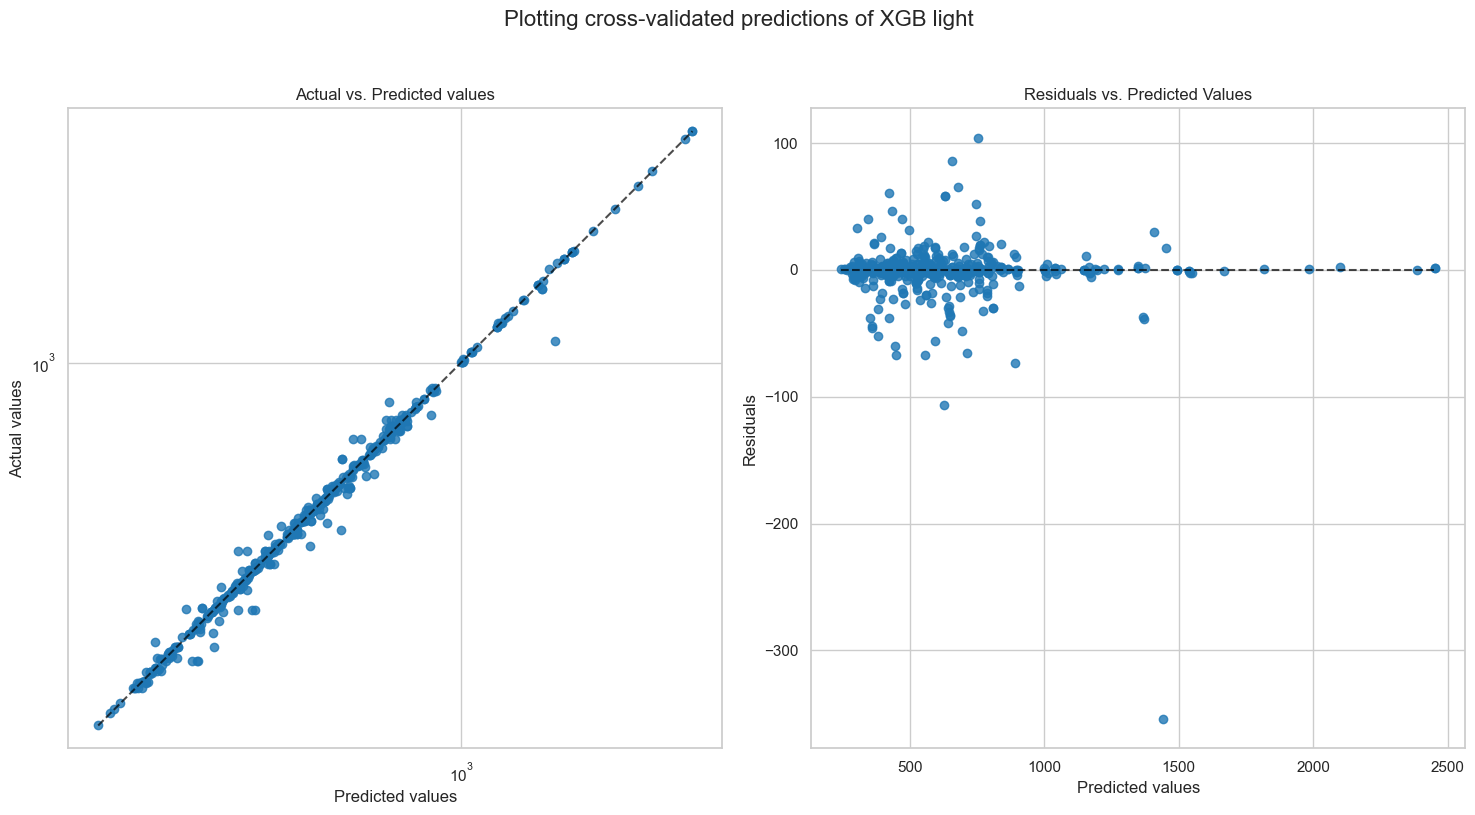

The mean residual of XGB light is: -0.3072127171791553


In [ ]:
plotPvA(decisionTree_final, "Decision Tree", X_osample, y_osample)
plotPvA(decisionTree_light_final, "Decision Tree light", X_osample, y_osample)

plotPvA(randomForest_final, "Random Forest", X_osample, y_osample)
plotPvA(randomForest_light_final, "Random Forest light", X_osample, y_osample)

plotPvA(xgb_final, "XGB", X_osample, y_osample)
plotPvA(xgb_light_final, "XGB light", X_osample, y_osample)

## 12 Safe models <a id="safe-models"></a>


In [ ]:
safe = False

In [ ]:
# Specify the file path where you want to save the model
folder='models/current'
models_to_safe = {
    "decisionTree": decisionTree_final,
    "randomForest": randomForest_final,
    "KNN": knn_final,
    "XGBoost": xgb_final,
    "SVM": svm_final,
    "decisionTree_light":decisionTree_light_final,
    "randomForest_light":randomForest_light_final,
    "XGBoost_light":xgb_light_final
}

def safeModel(models, folder):
    os.makedirs(folder, exist_ok=True)  # Create directory if it doesn't exist
    for key, values in models.items():
        path = folder+f'/{key}.joblib'
        #with open(path, 'wb') as f:
        dump(values, path)

In [ ]:
if safe:
    safeModel(models_to_safe,folder)

## 13 Debugging library versions <a id="debugging-libraries"></a>

Sklearn Version has to be >1.2.2
For that, Python>3.8 is required

### Pandas

In [ ]:
try:
    import pandas
    if pandas.__version__!='2.0.1':
        !pip install pandas==2.0.1
except:
    !pip pandas numpy==2.0.1

### Sklearn

In [ ]:
try:
    import sklearn
    if(sklearn.__version__!="1.2.2"):
        try:
            !pip install --upgrade numpy==1.23.5
            !pip install --upgrade pandas
            !pip install --upgrade scikit-learn==1.2.2
        except:
            print("Check your Python version. Has to be >3.8!")
            import sys
            print("Your Python version:", sys.version)
except:
    try:
        !pip install scikit-learn==1.2.2
        !pip install --upgrade numpy==1.23.5
    except:
        print("Check your Python version. Has to be >3.8!")
        import sys
        print("Your Python version:", sys.version)

### Numpy

In [ ]:
try:
    import numpy
    if numpy.__version__!="1.23.5":
        !pip install numpy==1.23.5
except:
    !pip install numpy==1.23.5

### Shap

In [ ]:
try:
    import shap
    if shap.__version__!="0.41.0":
        !pip install --upgrade shap==0.41.0
except:
    !pip install shap
    # For shap, numpy Version has to be <1.24
    !pip install --upgrade numpy == 1.23.5

### Numba, llvmlite (used in shap)

In [ ]:
try:
    import numba
    if numba.__version__!="0.57.0":
        !pip install --upgrade numba==0.57.0
except:
    !pip install numba==0.57.0

try:
    import llvmlite
    if llvmlite.__version__!="0.57.0":
        !pip install --upgrade llvmlite==0.40.0
except:
    !pip install llvmlite==0.40.0

False

### XGBoost

In [ ]:
try:
    import xgboost
except:
    !pip install xgboost

### Helper libraries

In [ ]:
try:
    import multiprocessing
    import psutil
    import threading
    import time
    import os
except:
    !pip install multiprocessing #'5.9.0'
    !pip install psutil #'5.9.0'
    !pip install threading #
    !pip install time #
    !pip install os #

# Still open Problems to be solved

## Commenting

## GUI
- Implement reset button
- Hidden advanced options should be deleted
- Registration in Date, not month
- KW/PS choosable
- Cat vars not prefilled

## Models
- Replace Onhot with label encoding!!!!
- New shap values
- Hyperparameter tuning for less overfitting
- Custom function for dataset splitting (stratification)?

## Add appendix
Drop light models
Mention in appendix as tests
Mention Onehot in appendix